In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/nlp/

/content/drive/.shortcut-targets-by-id/1hHGaf-koA0V3FjQP2dvs7HFCaVW94hPv/nlp


In [ ]:
import pandas as pd

from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold
import numpy as np

import torch

import matplotlib.pyplot as plt
import seaborn as sns

from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    TrainerCallback,
    EarlyStoppingCallback
)
from torch.utils.data import Dataset

import os
import zipfile
import json


In [ ]:
np.random.seed(42)
torch.manual_seed(42)

In [ ]:
import wandb

# Disable wandb logging for this script
wandb.init(mode="disabled")

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


In [ ]:
my_pal = ['1f77b4', 'ff8c1a', '2ca02c', 'd62728', '9467bd', 'c5b300', 'e377c2', '17becf']
my_pal = [f"#{c}" for c in my_pal]

sns.reset_defaults() # useful when adjusting style a lot
plt.rcParams['font.family']=['sans-serif']
sns.set_theme(context="paper", style="ticks",
              # palette="Set2",
              palette=my_pal,
              rc={
              "pdf.fonttype": 42,  # embed font in output
              "svg.fonttype": "none",  # embed font in output
              "figure.facecolor": "white",
              "figure.dpi": 150,
              "axes.facecolor": "None",
              "axes.spines.left": True,
              "axes.spines.bottom": True,
              "axes.spines.right": False,
              "axes.spines.top": False,
          },
          )

# Subtask 3: Manifestation Identification
Multi-label classification to classify how polarization is expressed, with multiple possible labels including Vilification, Extreme Language, Stereotype, Invalidation, Lack of Empathy, and Dehumanization.



In [ ]:
train = pd.read_csv('subtask3/train/swa.csv')
test = pd.read_csv('subtask3/dev/swa.csv')

train.head()

# Perform simple random split without stratification
train, val = train_test_split(
    train,
    test_size=0.2,
    random_state=42
)

train.head()

,id,text,stereotype,vilification,dehumanization,extreme_language,lack_of_empathy,invalidation
3875,swa_1e08a561fc1d7881fffb4822639b357f,kenya iuzw mtu apew share yake ama waturudishi...,0,0,0,0,0,0
1768,swa_b436d75df7d5cc4847f2c973740e49d0,bana rt mamzee especially hawa hapa twitter rt...,0,1,0,0,1,0
3250,swa_71b7ef26027e30d7f0e3025b5afb45ff,uliwaibia nani hao majembe la kutombwa pussy m...,0,0,0,0,0,0
6574,swa_fb121178c35ba35b1fafc735704824fa,Woi Museveni will kill us hio kamba hata ya ba...,0,1,0,0,0,1
2815,swa_1352a5d0c27ff8f79314abf4597a5046,mt hulipwa na supremacist mweupe kila wakati h...,0,0,0,0,0,0


In [ ]:
# Dataset class for Subtask 3 - Multi-label classification
class Polarizationtraindatset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding=False,
            max_length=self.max_length,
            return_tensors='pt'
        )

        # Ensure consistent tensor conversion for all items
        item = {key: encoding[key].squeeze() for key in encoding.keys()}
        # Use torch.float for multi-label classification (6 binary labels)
        item['labels'] = torch.tensor(label, dtype=torch.float)
        return item


class Polarizationtestdataset(torch.utils.data.Dataset):
    def __init__(self, texts, tokenizer, max_length=128):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx]) if pd.notna(self.texts[idx]) else ""
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding=False,
            max_length=self.max_length,
            return_tensors='pt'
        )
        item = {key: encoding[key].squeeze(0) for key in encoding.keys()}
        return item

In [ ]:
# Load the tokenizer
# cardiffnlp/twitter-roberta-base-hate-multiclass-latest
# metabloit/swahBERT
# microsoft/deberta-v3-base
# Davlan/afro-xlmr-base
# cardiffnlp/twitter-roberta-base-sentiment-latest
# FacebookAI/xlm-roberta-base
tokenizer = AutoTokenizer.from_pretrained('FacebookAI/xlm-roberta-base')

# Create train and Test dataset for multilabel
train_dataset = Polarizationtraindatset(
    train['text'].tolist(),
    train[['vilification','extreme_language','stereotype','invalidation','lack_of_empathy','dehumanization']].values.tolist(),
    tokenizer
)

val_dataset = Polarizationtraindatset(
    val['text'].tolist(),
    val[['vilification','extreme_language','stereotype','invalidation','lack_of_empathy','dehumanization']].values.tolist(),
    tokenizer
)

In [ ]:
# Load the model
model = AutoModelForSequenceClassification.from_pretrained('FacebookAI/xlm-roberta-base', num_labels=6, problem_type="multi_label_classification" ,ignore_mismatched_sizes=True)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Define training arguments
training_args = TrainingArguments(
    output_dir=f"/content/outputs",
    num_train_epochs=5,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    lr_scheduler_type="linear",
    eval_strategy="epoch",
    save_strategy="no",
    logging_steps=100,
    disable_tqdm=False,
    metric_for_best_model="f1_macro",
    load_best_model_at_end=False,
    greater_is_better=True,
    save_total_limit=1
)


# Define metrics function for multi-label classification
def compute_metrics_multilabel(p):
    # Sigmoid the predictions to get probabilities
    probs = torch.sigmoid(torch.from_numpy(p.predictions))
    # Convert probabilities to predicted labels (0 or 1)
    preds = (probs > 0.5).int().numpy()
    # Compute macro F1 score
    return {'f1_macro': f1_score(p.label_ids, preds, average='macro')}

In [ ]:
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics_multilabel,
    data_collator=DataCollatorWithPadding(tokenizer)
)

# Train the model
trainer.train()
log_history = trainer.state.log_history
# Evaluate the model on the validation set
eval_results = trainer.evaluate()
print(f"Macro F1 score on validation set for Subtask 3: {eval_results['eval_f1_macro']}")

Epoch,Training Loss,Validation Loss,F1 Macro
1,0.526700,0.514399,0.326160
2,0.495300,0.499888,0.414431
3,0.447600,0.514595,0.492804
4,0.431000,0.498795,0.450485
5,0.389600,0.514619,0.472230


Macro F1 score on validation set for Subtask 3: 0.4722302672514165


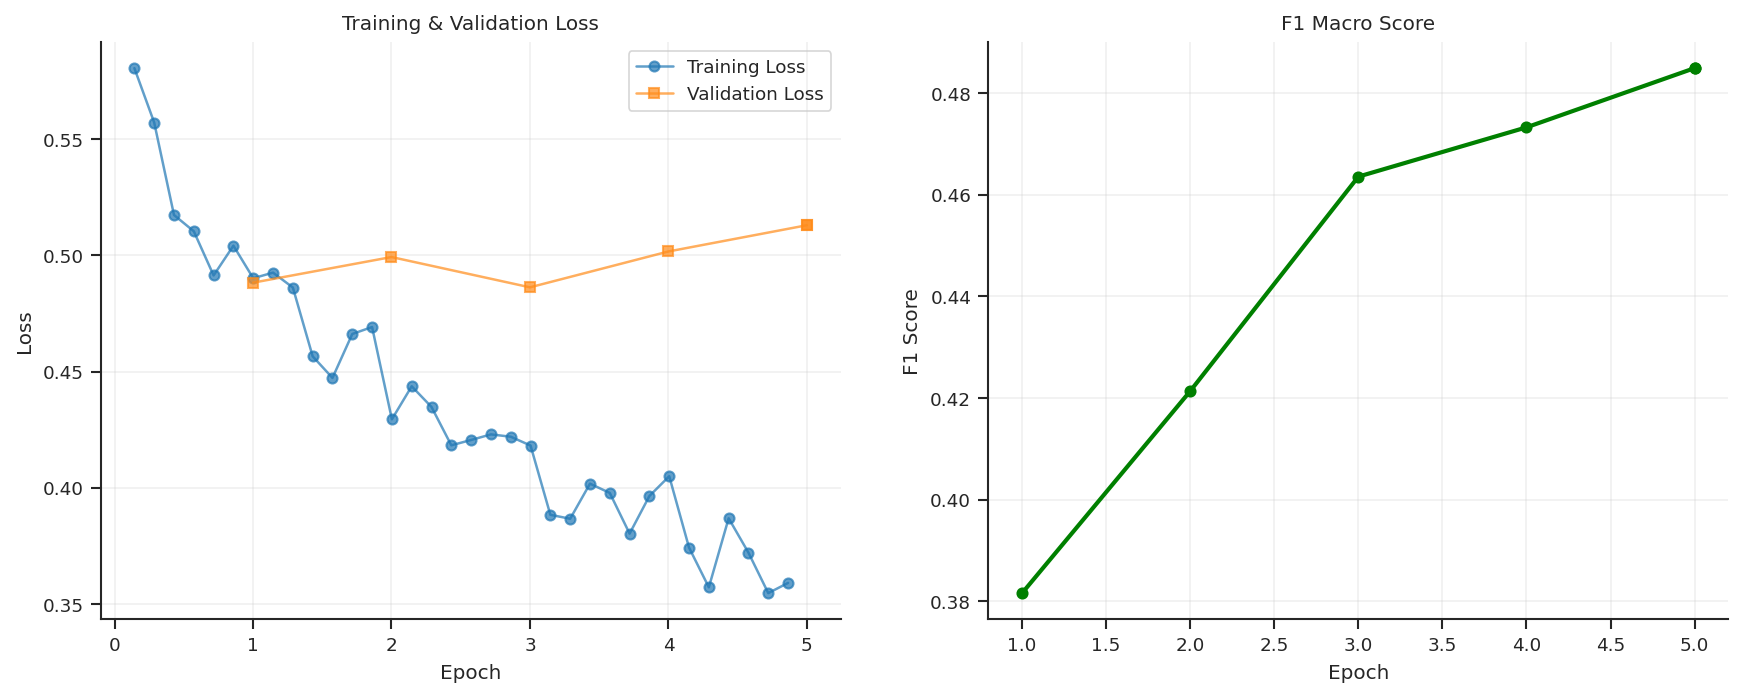

In [ ]:



# Convert to DataFrame for easier plotting
logs_df = pd.DataFrame(log_history)
# print(logs_df)

# Prepare data
train_logs = logs_df[logs_df['loss'].notna()]
eval_logs = logs_df[logs_df['eval_loss'].notna()]

# Create subplot mosaic
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: Both losses
axes[0].plot(train_logs['epoch'], train_logs['loss'], label='Training Loss', marker='o', alpha=0.7)
axes[0].plot(eval_logs['epoch'], eval_logs['eval_loss'], label='Validation Loss', marker='s', alpha=0.7)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training & Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Right plot: F1 Score
axes[1].plot(eval_logs['epoch'], eval_logs['eval_f1_macro'], marker='o', color='green', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('F1 Score')
axes[1].set_title('F1 Macro Score')
axes[1].grid(True, alpha=0.3)

# plt.tight_layout()
plt.savefig('single_train_task3_swa_afroxmlr',dpi=200,format='pdf' )
plt.show()

In [ ]:
# After training, make predictions on test set
print("\n" + "="*70)
print("Generating Predictions on Test Set")
print("="*70 + "\n")


LABEL_COLUMNS = ['vilification', 'extreme_language', 'stereotype',
                 'invalidation', 'lack_of_empathy', 'dehumanization']


test_dataset = Polarizationtestdataset(
    test['text'].tolist(),
    tokenizer
)

predictions = trainer.predict(test_dataset)


probs = torch.sigmoid(torch.from_numpy(predictions.predictions))


final_predictions = (probs > 0.5).int().numpy()

# Save predictions
results_df = pd.DataFrame({'id': test['id']})
for i, col in enumerate(LABEL_COLUMNS):
    results_df[col] = final_predictions[:, i]

# Create output directory
os.makedirs('subtask_3', exist_ok=True)
csv_path = 'subtask_3/pred_swa.csv'
results_df.to_csv(csv_path, index=False)

print(f"\n✓ Saved predictions to {csv_path}")
print(f"\nSample predictions:")
print(results_df.head(10))
print(f"\nPrediction distribution:")
print(results_df[LABEL_COLUMNS].sum())

# Save the model
print("\n" + "="*70)
print("Saving Model")
print("="*70 + "\n")

# model_save_path = "/content/outputs/final_model_eng"
# trainer.save_model(model_save_path)
# tokenizer.save_pretrained(model_save_path)
# print(f"✓ Model saved to {model_save_path}")


import zipfile
zip_filename = 'subtask_3_swa_xlmroberta.zip'
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk('subtask_3'):
        for file in files:
            file_path = os.path.join(root, file)
            arcname = os.path.join(os.path.basename(root), file)
            zipf.write(file_path, arcname)

print(f"✓ Created compressed file: {zip_filename}")


print("\n" + "="*70)
print("Final Results Summary")
print("="*70)
print(f"\nValidation Macro F1: {eval_results['eval_f1_macro']:.4f}")
print(f"Predictions saved to: {csv_path}")
# print(f"Model saved to: {model_save_path}")
print(f"Compressed file: {zip_filename}")


Generating Predictions on Test Set




✓ Saved predictions to subtask_3/pred_swa.csv

Sample predictions:
                                     id  vilification  extreme_language  \
0  swa_a5748df181277341143f7da4175add4a             1                 0   
1  swa_2df0d42f9b49ea2e4fb006b2e6604e6d             1                 0   
2  swa_3718757514005767302b7220b08e409d             1                 0   
3  swa_9fa3337a35cce723d60c06056d422330             1                 0   
4  swa_5c39ac8ef70345e9e3c21a47f8769bc0             1                 0   
5  swa_257c286fa7c51cb7c688945a23f2628c             1                 0   
6  swa_36ab93dbc14eea454ab02c2600d1a8f4             1                 0   
7  swa_d5efac5c104f931cdc0233ae0ba51d83             1                 0   
8  swa_bb5632760ec46cf270238c2163b3aabb             1                 0   
9  swa_96b4fdd8cfb089b397d769319be3006b             1                 0   

   stereotype  invalidation  lack_of_empathy  dehumanization  
0           1             1                

# big function

In [ ]:


# cardiffnlp/twitter-roberta-base-hate-multiclass-latest
# metabloit/swahBERT
# microsoft/deberta-v3-base
# Davlan/afro-xlmr-base
# cardiffnlp/twitter-roberta-base-sentiment-latest
# FacebookAI/xlm-roberta-base
CONFIG = {
    'english': {#FacebookAI/xlm-roberta-base
        'model_name': 'microsoft/deberta-v3-base',
        'train_file': 'subtask3/train/eng.csv',
        'test_file': 'subtask3/dev/eng.csv',
        'output_name': 'eng'
    },
    'swahili': {#Davlan/afro-xlmr-large
        'model_name': 'FacebookAI/xlm-roberta-base',
        'train_file': 'subtask3/train/swa.csv',
        'test_file': 'subtask3/dev/swa.csv',
        'output_name': 'swa'
    }
}

# Subtask 3 label columns (multi-label binary classification)
LABEL_COLUMNS = ['stereotype', 'vilification', 'dehumanization',
                 'extreme_language', 'lack_of_empathy', 'invalidation']

# Select language
LANGUAGE = 'english'
config = CONFIG[LANGUAGE]

In [ ]:
# @title Multiclass Large

# ============================================
# Dataset Classes
# ============================================
class Subtask3Dataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding=False,
            max_length=self.max_length,
            return_tensors='pt'
        )

        item = {key: encoding[key].squeeze() for key in encoding.keys()}
        item['labels'] = torch.tensor(label, dtype=torch.float)
        return item

class Subtask3TestDataset(torch.utils.data.Dataset):
    def __init__(self, texts, tokenizer, max_length=128):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx]) if pd.notna(self.texts[idx]) else ""
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding=False,
            max_length=self.max_length,
            return_tensors='pt'
        )

        item = {key: encoding[key].squeeze(0) for key in encoding.keys()}
        return item

# ============================================
# Custom Trainer with Combined Metric
# ============================================
class CombinedMetricTrainer(Trainer):
    """Custom Trainer that optimizes for both F1 score and loss reduction"""
    def __init__(self, *args, f1_weight=0.7, loss_weight=0.3, **kwargs):
        super().__init__(*args, **kwargs)
        self.f1_weight = f1_weight
        self.loss_weight = loss_weight
        self.train_losses = []

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        """Track training loss"""
        outputs = model(**inputs)
        loss = outputs.loss
        self.train_losses.append(loss.item())
        return (loss, outputs) if return_outputs else loss

    def evaluate(self, eval_dataset=None, ignore_keys=None, metric_key_prefix="eval"):
        """Add combined score metric"""
        metrics = super().evaluate(eval_dataset, ignore_keys, metric_key_prefix)

        f1 = metrics.get(f'{metric_key_prefix}_f1_macro', 0)
        loss = metrics.get(f'{metric_key_prefix}_loss', 0)

        normalized_loss = min(loss / 2.0, 1.0)
        combined_score = (self.f1_weight * f1) - (self.loss_weight * normalized_loss)
        metrics[f'{metric_key_prefix}_combined_score'] = combined_score

        if self.train_losses:
            avg_train_loss = np.mean(self.train_losses[-100:])
            metrics[f'{metric_key_prefix}_train_loss_recent'] = avg_train_loss

        return metrics

# ============================================
# Enhanced Monitoring Callback
# ============================================
class EnhancedMonitoringCallback(TrainerCallback):
    """Callback to monitor and log F1, train loss, and eval loss"""
    def __init__(self):
        self.best_f1 = -float('inf')
        self.best_eval_loss = float('inf')
        self.best_train_loss = float('inf')
        self.best_combined = -float('inf')
        self.history = {
            'epoch': [],
            'train_loss': [],
            'eval_loss': [],
            'eval_f1': [],
            'combined_score': []
        }

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs and 'loss' in logs:
            if logs['loss'] < self.best_train_loss:
                self.best_train_loss = logs['loss']

    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        if metrics is not None:
            epoch = state.epoch
            train_loss = metrics.get('train_loss', state.log_history[-1].get('loss', 0) if state.log_history else 0)
            eval_loss = metrics.get('eval_loss', 0)
            eval_f1 = metrics.get('eval_f1_macro', 0)
            combined_score = metrics.get('eval_combined_score', 0)

            self.history['epoch'].append(epoch)
            self.history['train_loss'].append(train_loss)
            self.history['eval_loss'].append(eval_loss)
            self.history['eval_f1'].append(eval_f1)
            self.history['combined_score'].append(combined_score)

            if eval_f1 > self.best_f1:
                self.best_f1 = eval_f1
            if eval_loss < self.best_eval_loss:
                self.best_eval_loss = eval_loss
            if combined_score > self.best_combined:
                self.best_combined = combined_score

            print(f"\n{'='*70}")
            print(f"Epoch {epoch:.1f} Metrics:")
            print(f"{'='*70}")
            print(f"  F1 Score:        {eval_f1:.4f} (Best: {self.best_f1:.4f})")
            print(f"  Eval Loss:       {eval_loss:.4f} (Best: {self.best_eval_loss:.4f})")
            print(f"  Train Loss:      {train_loss:.4f} (Best: {self.best_train_loss:.4f})")
            print(f"  Combined Score:  {combined_score:.4f} (Best: {self.best_combined:.4f})")

            if eval_f1 == self.best_f1:
                print(f"  ✓ NEW BEST F1!")
            if eval_loss == self.best_eval_loss:
                print(f"  ✓ NEW BEST EVAL LOSS!")
            if combined_score == self.best_combined:
                print(f"  ✓ NEW BEST COMBINED SCORE!")
            print(f"{'='*70}\n")

# ============================================
# Early Stopping with Combined Metric
# ============================================
class CombinedEarlyStoppingCallback(TrainerCallback):
    """Early stopping based on combined F1 and loss metric"""
    def __init__(self, patience=5):
        self.patience = patience
        self.best_combined_score = -float('inf')
        self.patience_counter = 0

    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        if metrics is not None:
            combined_score = metrics.get('eval_combined_score', -float('inf'))

            if combined_score > self.best_combined_score:
                self.best_combined_score = combined_score
                self.patience_counter = 0
            else:
                self.patience_counter += 1

            if self.patience_counter >= self.patience:
                print(f"\n⚠ Early stopping triggered after {self.patience} epochs without improvement")
                print(f"Best combined score: {self.best_combined_score:.4f}")
                control.should_training_stop = True

# ============================================
# Compute Metrics for Multi-Label
# ============================================
def compute_metrics_multilabel(p):
    """Compute macro F1 for multi-label classification"""
    probs = torch.sigmoid(torch.from_numpy(p.predictions))
    preds = (probs > 0.5).int().numpy()
    return {'f1_macro': f1_score(p.label_ids, preds, average='macro', zero_division=0)}

# ============================================
# Create Stratification Key for Multi-Label
# ============================================
def create_stratify_key(df, label_columns):
    """Create a stratification key for multi-label data"""
    return df[label_columns].apply(lambda row: '_'.join(row.astype(str)), axis=1)

# ============================================
# K-Fold Cross-Validation with Enhanced Training
# ============================================
def train_kfold_cv(train_df, model_name, label_columns, n_splits=5, seed=42):
    """Train model using K-Fold Cross-Validation for multi-label classification"""

    # Create stratification key
    train_df['stratify_key'] = create_stratify_key(train_df, label_columns)

    # Check for rare combinations
    value_counts = train_df['stratify_key'].value_counts()
    valid_keys = value_counts[value_counts >= 2].index

    # Handle rare combinations
    train_df['stratify_col'] = train_df['stratify_key'].apply(
        lambda x: x if x in valid_keys else 'rare'
    )

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    fold_models = []
    fold_scores = []
    fold_metrics = []

    tokenizer = AutoTokenizer.from_pretrained(model_name)

    print(f"\n{'='*70}")
    print(f"Starting {n_splits}-Fold Cross-Validation")
    print(f"Model: {model_name}")
    print(f"Total samples: {len(train_df)}")
    print(f"Task: Multi-Label Classification ({len(label_columns)} labels)")
    print(f"Optimization: Maximize F1 + Minimize Loss")
    print(f"{'='*70}\n")

    for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df['stratify_col'])):
        print(f"\n{'='*70}")
        print(f"FOLD {fold + 1}/{n_splits}")
        print(f"{'='*70}")

        train_fold = train_df.iloc[train_idx]
        val_fold = train_df.iloc[val_idx]

        print(f"Train size: {len(train_fold)}, Val size: {len(val_fold)}")

        # Create datasets
        train_dataset = Subtask3Dataset(
            train_fold['text'].tolist(),
            train_fold[label_columns].values.tolist(),
            tokenizer
        )
        val_dataset = Subtask3Dataset(
            val_fold['text'].tolist(),
            val_fold[label_columns].values.tolist(),
            tokenizer
        )

        # Load config and set dropout parameters
        model_config = AutoConfig.from_pretrained(model_name)
        model_config.hidden_dropout_prob = 0.2
        model_config.attention_probs_dropout_prob = 0.2
        model_config.classifier_dropout = 0.3
        model_config.num_labels = len(label_columns)
        model_config.problem_type = "multi_label_classification"

        # Initialize model with dropout
        model = AutoModelForSequenceClassification.from_pretrained(
            model_name,
            config=model_config,
            ignore_mismatched_sizes=True
        )

        # Enhanced training arguments
        training_args = TrainingArguments(
            output_dir=f"/content/outputs/fold_{fold+1}",
            num_train_epochs=5,
            learning_rate=2e-5,
            lr_scheduler_type="linear",
            warmup_ratio=0.15,
            per_device_train_batch_size=32,
            per_device_eval_batch_size=32,
            gradient_accumulation_steps=2,
            weight_decay=0.01,
            max_grad_norm=1.0,
            label_smoothing_factor=0.1,
            eval_strategy="epoch",
            save_strategy="epoch",
            logging_steps=25,
            save_total_limit=2,
            load_best_model_at_end=True,
            metric_for_best_model="combined_score",
            greater_is_better=True,
            fp16=True,
            dataloader_num_workers=2,
            disable_tqdm=False,
            report_to="none"
        )

        # Initialize callbacks
        monitoring_callback = EnhancedMonitoringCallback()
        early_stopping_callback = CombinedEarlyStoppingCallback(patience=5)

        # Initialize custom trainer
        trainer = CombinedMetricTrainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            compute_metrics=compute_metrics_multilabel,
            data_collator=DataCollatorWithPadding(tokenizer),
            callbacks=[monitoring_callback, early_stopping_callback],
            f1_weight=0.7,
            loss_weight=0.3
        )

        # Train
        print(f"\nTraining Fold {fold + 1}...")
        trainer.train()

        # Final evaluation
        eval_results = trainer.evaluate()
        fold_score = eval_results['eval_f1_macro']
        fold_eval_loss = eval_results['eval_loss']
        fold_combined = eval_results['eval_combined_score']

        fold_scores.append(fold_score)
        fold_metrics.append({
            'fold': fold + 1,
            'f1': fold_score,
            'eval_loss': fold_eval_loss,
            'combined_score': fold_combined,
            'best_f1': monitoring_callback.best_f1,
            'best_eval_loss': monitoring_callback.best_eval_loss,
            'best_train_loss': monitoring_callback.best_train_loss
        })

        print(f"\n{'='*70}")
        print(f"Fold {fold + 1} Final Results:")
        print(f"{'='*70}")
        print(f"  F1 Score:       {fold_score:.4f}")
        print(f"  Eval Loss:      {fold_eval_loss:.4f}")
        print(f"  Combined Score: {fold_combined:.4f}")
        print(f"{'='*70}")

        # Save model info
        fold_models.append({
            'model': model,
            'tokenizer': tokenizer,
            'score': fold_score,
            'eval_loss': fold_eval_loss,
            'combined_score': fold_combined,
            'fold': fold + 1,
            'history': monitoring_callback.history
        })

    # Print summary
    print(f"\n{'='*70}")
    print(f"CROSS-VALIDATION SUMMARY")
    print(f"{'='*70}")
    print(f"\nPer-Fold Results:")
    print(f"{'Fold':<8} {'F1 Score':<12} {'Eval Loss':<12} {'Combined':<12}")
    print(f"{'-'*50}")
    for metrics in fold_metrics:
        print(f"{metrics['fold']:<8} {metrics['f1']:<12.4f} {metrics['eval_loss']:<12.4f} {metrics['combined_score']:<12.4f}")

    print(f"\nAggregate Statistics:")
    print(f"  Mean F1:       {np.mean(fold_scores):.4f} ± {np.std(fold_scores):.4f}")
    print(f"  Mean Eval Loss:{np.mean([m['eval_loss'] for m in fold_metrics]):.4f} ± {np.std([m['eval_loss'] for m in fold_metrics]):.4f}")
    print(f"  Mean Combined: {np.mean([m['combined_score'] for m in fold_metrics]):.4f} ± {np.std([m['combined_score'] for m in fold_metrics]):.4f}")
    print(f"{'='*70}\n")

    # Plot results
    plot_all_folds(fold_models, config['model_name'], LANGUAGE)

    return fold_models, fold_metrics

# ============================================
# Plotting Function
# ============================================
def plot_all_folds(fold_models, model_name, language):
    """Plot training history for all folds with complementary colors"""
    import matplotlib.pyplot as plt

    cfg = CONFIG[language]
    short_model_name = cfg['model_name'].split('/')[-1]

    n_folds = len(fold_models)
    colors = plt.cm.tab10(np.linspace(0, 0.9, n_folds))

    fig = plt.figure(figsize=(16, 6))
    mosaic = [['losses', 'f1']]
    axes = fig.subplot_mosaic(mosaic)

    # Left plot: Losses for all folds
    for idx, fold_model in enumerate(fold_models):
        history = fold_model['history']
        fold_num = fold_model['fold']
        color = colors[idx]

        axes['losses'].plot(history['epoch'], history['train_loss'],
                           label=f'Fold {fold_num} Train',
                           alpha=0.7,
                           linestyle='--',
                           color=color,
                           linewidth=2)
        axes['losses'].plot(history['epoch'], history['eval_loss'],
                           label=f'Fold {fold_num} Val',
                           alpha=0.9,
                           color=color,
                           linewidth=2)

    axes['losses'].set_xlabel('Epoch', fontsize=11)
    axes['losses'].set_ylabel('Loss', fontsize=11)
    axes['losses'].set_title(f'Training & Validation Loss - {short_model_name}', fontsize=12, fontweight='bold')
    axes['losses'].legend(fontsize=9, framealpha=0.9)
    axes['losses'].grid(True, alpha=0.3, linestyle='--')

    # Right plot: F1 scores for all folds
    for idx, fold_model in enumerate(fold_models):
        history = fold_model['history']
        fold_num = fold_model['fold']
        color = colors[idx]

        axes['f1'].plot(history['epoch'], history['eval_f1'],
                       label=f'Fold {fold_num}',
                       marker='o',
                       alpha=0.85,
                       color=color,
                       linewidth=2,
                       markersize=6)

    axes['f1'].set_xlabel('Epoch', fontsize=11)
    axes['f1'].set_ylabel('F1 Score', fontsize=11)
    axes['f1'].set_title(f'F1 Macro Score - {short_model_name}', fontsize=12, fontweight='bold')
    axes['f1'].legend(fontsize=9, framealpha=0.9)
    axes['f1'].grid(True, alpha=0.3, linestyle='--')

    plt.tight_layout()
    plot_filename = f'subtask3_{cfg["output_name"]}_{short_model_name}.pdf'
    plt.savefig(plot_filename, dpi=200, format='pdf')
    print(f"\n✓ Plot saved to: {plot_filename}")
    plt.show()

# ============================================
# Ensemble Prediction for Multi-Label
# ============================================
def ensemble_predict_multilabel(fold_models, test_dataset, method='weighted', threshold=0.5):
    """Make ensemble predictions for multi-label classification"""
    all_predictions = []
    weights = []

    for i, fold_model in enumerate(fold_models):
        print(f"Getting predictions from Fold {i+1} (F1: {fold_model['score']:.4f})...")

        model = fold_model['model']
        tokenizer = fold_model['tokenizer']

        trainer = Trainer(
            model=model,
            data_collator=DataCollatorWithPadding(tokenizer)
        )

        predictions = trainer.predict(test_dataset)
        probs = torch.sigmoid(torch.tensor(predictions.predictions))
        all_predictions.append(probs.numpy())

        if method == 'weighted':
            weights.append(fold_model['score'])
        elif method == 'weighted_combined':
            weights.append(fold_model['combined_score'])
        else:
            weights.append(1.0)

    # Normalize weights
    weights = np.array(weights)
    weights = weights / weights.sum()

    print(f"\nEnsemble weights: {weights}")

    # Weighted average of probabilities
    weighted_probs = np.zeros_like(all_predictions[0])
    for pred, weight in zip(all_predictions, weights):
        weighted_probs += pred * weight

    # Apply threshold
    final_predictions = (weighted_probs > threshold).astype(int)

    return final_predictions

# ============================================
# Save Models in Compressed Format
# ============================================
def save_fold_models(fold_models, fold_metrics, language):
    """Save all fold models and metrics in a single compressed file"""
    cfg = CONFIG[language]
    short_model_name = cfg['model_name'].split('/')[-1]

    # Create temporary directory for models
    temp_dir = f"/content/temp_models_{cfg['output_name']}"
    os.makedirs(temp_dir, exist_ok=True)

    # Save best model
    best_fold_idx = np.argmax([m['combined_score'] for m in fold_metrics])
    best_fold_model = fold_models[best_fold_idx]

    best_model_dir = os.path.join(temp_dir, "best_model")
    os.makedirs(best_model_dir, exist_ok=True)
    best_fold_model['model'].save_pretrained(best_model_dir)
    best_fold_model['tokenizer'].save_pretrained(best_model_dir)

    print(f"\n✓ Best model prepared (Fold {best_fold_model['fold']})")
    print(f"✓ F1 Score: {best_fold_model['score']:.4f}")
    print(f"✓ Combined Score: {best_fold_model['combined_score']:.4f}")

    # Save all fold models
    for fold_model in fold_models:
        fold_dir = os.path.join(temp_dir, f"fold_{fold_model['fold']}")
        os.makedirs(fold_dir, exist_ok=True)
        fold_model['model'].save_pretrained(fold_dir)
        fold_model['tokenizer'].save_pretrained(fold_dir)
        print(f"✓ Prepared Fold {fold_model['fold']}")

    # Save metrics
    metrics_path = os.path.join(temp_dir, "fold_metrics.json")
    with open(metrics_path, 'w') as f:
        json.dump(fold_metrics, f, indent=2)

    # Save model info
    model_info = {
        'language': language,
        'model_name': cfg['model_name'],
        'short_model_name': short_model_name,
        'best_fold': best_fold_model['fold'],
        'best_f1': best_fold_model['score'],
        'best_combined_score': best_fold_model['combined_score'],
        'n_folds': len(fold_models),
        'label_columns': LABEL_COLUMNS
    }
    info_path = os.path.join(temp_dir, "model_info.json")
    with open(info_path, 'w') as f:
        json.dump(model_info, f, indent=2)

    # Compress everything
    zip_filename = f"subtask3_{cfg['output_name']}_{short_model_name}.zip"
    final_path = f"/content/drive/MyDrive/Colab Notebooks/nlp/{zip_filename}"

    print(f"\nCompressing all models...")
    with zipfile.ZipFile(final_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(temp_dir):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, temp_dir)
                zipf.write(file_path, arcname)

    # Clean up temp directory
    import shutil
    shutil.rmtree(temp_dir)

    print(f"\n{'='*70}")
    print(f"✓ All models saved to compressed file:")
    print(f"  {final_path}")
    print(f"  Model: {short_model_name}")
    print(f"  Language: {language}")
    print(f"{'='*70}\n")

# ============================================
# LOAD SAVED MODEL FOR PREDICTION
# ============================================
def load_saved_model(language='english', model_name=None):
    """Load the best saved model from compressed file"""
    cfg = CONFIG[language]

    if model_name is None:
        short_model_name = cfg['model_name'].split('/')[-1]
    else:
        short_model_name = model_name.split('/')[-1] if '/' in model_name else model_name

    zip_path = f"/content/drive/MyDrive/Colab Notebooks/nlp/subtask3_{cfg['output_name']}_{short_model_name}.zip"

    print(f"Loading model from: {zip_path}")

    # Extract to temp directory
    temp_extract_dir = f"/content/temp_extract_{cfg['output_name']}"

    with zipfile.ZipFile(zip_path, 'r') as zipf:
        zipf.extractall(temp_extract_dir)

    # Load model info
    with open(os.path.join(temp_extract_dir, "model_info.json"), 'r') as f:
        model_info = json.load(f)

    # Load best model
    best_model_dir = os.path.join(temp_extract_dir, "best_model")
    model = AutoModelForSequenceClassification.from_pretrained(best_model_dir)
    tokenizer = AutoTokenizer.from_pretrained(best_model_dir)

    print(f"✓ Model loaded successfully!")
    print(f"  Model: {model_info['short_model_name']}")
    print(f"  Best Fold: {model_info['best_fold']}")
    print(f"  F1 Score: {model_info['best_f1']:.4f}")

    return model, tokenizer, model_info

# ============================================
# LOAD ALL FOLD MODELS FOR ENSEMBLE
# ============================================
def load_all_fold_models(language='english', model_name=None):
    """Load all saved fold models from compressed file for ensemble prediction"""
    cfg = CONFIG[language]

    if model_name is None:
        short_model_name = cfg['model_name'].split('/')[-1]
    else:
        short_model_name = model_name.split('/')[-1] if '/' in model_name else model_name

    zip_path = f"/content/drive/MyDrive/Colab Notebooks/nlp/subtask3_{cfg['output_name']}_{short_model_name}.zip"

    print(f"\nLoading all fold models from: {zip_path}")

    # Extract to temp directory
    temp_extract_dir = f"/content/temp_extract_{cfg['output_name']}"

    with zipfile.ZipFile(zip_path, 'r') as zipf:
        zipf.extractall(temp_extract_dir)

    # Load model info and metrics
    with open(os.path.join(temp_extract_dir, "model_info.json"), 'r') as f:
        model_info = json.load(f)

    with open(os.path.join(temp_extract_dir, "fold_metrics.json"), 'r') as f:
        fold_metrics = json.load(f)

    n_folds = model_info['n_folds']
    fold_models = []

    print(f"Loading {n_folds} fold models for {language} ({short_model_name})...")

    for fold_num in range(1, n_folds + 1):
        fold_dir = os.path.join(temp_extract_dir, f"fold_{fold_num}")

        print(f"  Loading Fold {fold_num}...")

        model = AutoModelForSequenceClassification.from_pretrained(fold_dir)
        tokenizer = AutoTokenizer.from_pretrained(fold_dir)

        fold_metric = fold_metrics[fold_num - 1]

        fold_models.append({
            'model': model,
            'tokenizer': tokenizer,
            'fold': fold_num,
            'score': fold_metric['f1'],
            'eval_loss': fold_metric['eval_loss'],
            'combined_score': fold_metric['combined_score']
        })

        print(f"  ✓ Fold {fold_num} loaded (F1: {fold_metric['f1']:.4f}, Loss: {fold_metric['eval_loss']:.4f})")

    print(f"\n✓ All {n_folds} models loaded successfully!")

    return fold_models

# ============================================
# PREDICT WITH SAVED MODEL
# ============================================
def predict_with_saved_model(test_csv_path, language='english', model_name=None,
                             output_csv='predictions.csv', threshold=0.5):
    """Make predictions using saved best model"""
    # Load saved model
    model, tokenizer, model_info = load_saved_model(language, model_name)

    # Load test data
    test = pd.read_csv(test_csv_path)
    print(f"Test size: {len(test)}")

    # Create test dataset
    test_dataset = Subtask3TestDataset(test['text'].tolist(), tokenizer)

    # Create trainer for prediction
    trainer = Trainer(
        model=model,
        data_collator=DataCollatorWithPadding(tokenizer)
    )

    # Make predictions
    print("Making predictions...")
    predictions = trainer.predict(test_dataset)
    probs = torch.sigmoid(torch.tensor(predictions.predictions))
    predicted_labels = (probs > threshold).int().numpy()

    # Save results
    label_cols = model_info['label_columns']
    results_df = pd.DataFrame({'id': test['id']})
    for i, col in enumerate(label_cols):
        results_df[col] = predicted_labels[:, i]

    results_df.to_csv(output_csv, index=False)

    print(f"✓ Predictions saved to: {output_csv}")
    print(f"\nSample predictions:")
    print(results_df.head())
    print(f"\nPrediction distribution:")
    print(results_df[label_cols].sum())

    return results_df

# ============================================
# ENSEMBLE PREDICT WITH SAVED MODELS
# ============================================
def ensemble_predict_with_saved_models(test_csv_path, language='english', model_name=None,
                                       method='weighted_combined',
                                       output_csv='ensemble_predictions.csv',
                                       threshold=0.5):
    """Make ensemble predictions using all saved fold models"""
    # Load all fold models
    fold_models = load_all_fold_models(language, model_name)

    # Load test data
    test = pd.read_csv(test_csv_path)
    print(f"\nTest size: {len(test)}")

    # Create test dataset
    tokenizer = fold_models[0]['tokenizer']
    test_dataset = Subtask3TestDataset(test['text'].tolist(), tokenizer)

    # Make ensemble predictions
    print(f"\nMaking ensemble predictions with method: {method}")
    final_predictions = ensemble_predict_multilabel(fold_models, test_dataset, method=method, threshold=threshold)

    # Save results
    results_df = pd.DataFrame({'id': test['id']})
    for i, col in enumerate(LABEL_COLUMNS):
        results_df[col] = final_predictions[:, i]

    results_df.to_csv(output_csv, index=False)

    print(f"\n✓ Ensemble predictions saved to: {output_csv}")
    print(f"\nSample predictions:")
    print(results_df.head(10))
    print(f"\nPrediction distribution:")
    print(results_df[LABEL_COLUMNS].sum())

    return results_df

# ============================================
# CONTINUE TRAINING SAVED MODEL
# ============================================
def continue_training(train_csv_path, language='english', model_name=None, additional_epochs=5):
    """Continue training a saved model"""
    # Load saved model
    model, tokenizer, model_info = load_saved_model(language, model_name)

    # Load training data
    train = pd.read_csv(train_csv_path)
    print(f"Train size: {len(train)}")

    # Create stratification key
    train['stratify_key'] = create_stratify_key(train, LABEL_COLUMNS)

    # Handle rare combinations
    value_counts = train['stratify_key'].value_counts()
    valid_keys = value_counts[value_counts >= 2].index
    train['stratify_col'] = train['stratify_key'].apply(
        lambda x: x if x in valid_keys else 'rare'
    )

    # Split into train/val
    train_split, val_split = train_test_split(
        train,
        test_size=0.2,
        stratify=train['stratify_col'],
        random_state=42
    )

    # Create datasets
    train_dataset = Subtask3Dataset(
        train_split['text'].tolist(),
        train_split[LABEL_COLUMNS].values.tolist(),
        tokenizer
    )
    val_dataset = Subtask3Dataset(
        val_split['text'].tolist(),
        val_split[LABEL_COLUMNS].values.tolist(),
        tokenizer
    )

    # Training arguments
    training_args = TrainingArguments(
        output_dir=f"/content/outputs/continued_training",
        num_train_epochs=additional_epochs,
        learning_rate=1e-5,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=32,
        gradient_accumulation_steps=2,
        warmup_ratio=0.1,
        weight_decay=0.01,
        lr_scheduler_type="cosine",
        eval_strategy="epoch",
        save_strategy="epoch",
        logging_steps=25,
        load_best_model_at_end=True,
        metric_for_best_model="f1_macro",
        greater_is_better=True,
        fp16=True,
        dataloader_num_workers=2,
    )

    # Initialize trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics_multilabel,
        data_collator=DataCollatorWithPadding(tokenizer)
    )

    # Continue training
    print(f"\nContinuing training for {additional_epochs} epochs...")
    trainer.train()

    # Evaluate
    eval_results = trainer.evaluate()
    print(f"\n✓ Final F1 Score: {eval_results['eval_f1_macro']:.4f}")

    # Save updated model
    cfg = CONFIG[language]
    short_model_name = model_info['short_model_name']
    updated_model_dir = f"/content/temp_updated_model"
    os.makedirs(updated_model_dir, exist_ok=True)
    trainer.save_model(updated_model_dir)
    tokenizer.save_pretrained(updated_model_dir)

    # Compress updated model
    zip_filename = f"subtask3_{cfg['output_name']}_{short_model_name}_updated.zip"
    final_path = f"/content/drive/MyDrive/Colab Notebooks/nlp/{zip_filename}"

    with zipfile.ZipFile(final_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(updated_model_dir):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, updated_model_dir)
                zipf.write(file_path, arcname)

    print(f"✓ Updated model saved to: {final_path}")

    return trainer

# ============================================
# Main Training Pipeline
# ============================================
def main():
    print(f"Loading data for {LANGUAGE}...")
    train = pd.read_csv(config['train_file'])
    test = pd.read_csv(config['test_file'])

    print(f"Train size: {len(train)}")
    print(f"Test size: {len(test)}")
    print(f"\nLabel distribution:")
    print(train[LABEL_COLUMNS].sum())

    # Train with K-Fold CV
    fold_models, fold_metrics = train_kfold_cv(
        train,
        config['model_name'],
        LABEL_COLUMNS,
        n_splits=5,
        seed=42
    )



    # Create test dataset
    tokenizer = AutoTokenizer.from_pretrained(config['model_name'])
    test_dataset = Subtask3TestDataset(test['text'].tolist(), tokenizer)

    # Ensemble predictions
    print("\n" + "="*70)
    print("Making Weighted Ensemble Predictions")
    print("="*70 + "\n")

    final_predictions = ensemble_predict_multilabel(
        fold_models,
        test_dataset,
        method='weighted_combined',
        threshold=0.5
    )
    # Save models
    save_fold_models(fold_models, fold_metrics, LANGUAGE)

    # Save predictions
    results_df = pd.DataFrame({'id': test['id']})
    for i, col in enumerate(LABEL_COLUMNS):
        results_df[col] = final_predictions[:, i]

    os.makedirs('subtask_3', exist_ok=True)
    csv_path = f'subtask_3/pred_{config["output_name"]}.csv'
    results_df.to_csv(csv_path, index=False)

    print(f"\n✓ Saved predictions to {csv_path}")
    print(f"\nSample predictions:")
    print(results_df.head(10))
    print(f"\nPrediction distribution:")
    print(results_df[LABEL_COLUMNS].sum())

    # Compress
    zip_filename = f'subtask_3_{config["output_name"]}_ensemble.zip'
    with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk('subtask_3'):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.join(os.path.basename(root), file)
                zipf.write(file_path, arcname)

    print(f"✓ Created compressed file: {zip_filename}")



Loading data for english...
Train size: 3222
Test size: 160

Label distribution:
stereotype          487
vilification        858
dehumanization      391
extreme_language    770
lack_of_empathy     357
invalidation        586
dtype: int64


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]


Starting 5-Fold Cross-Validation
Model: FacebookAI/xlm-roberta-base
Total samples: 3222
Task: Multi-Label Classification (6 labels)
Optimization: Maximize F1 + Minimize Loss


FOLD 1/5
Train size: 2577, Val size: 645


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/transformers/trainer.py:768: UserWarning: Label smoothing is not compatible with multi-label classification. Disabling label smoothing for this training run.
  warnings.warn(



Training Fold 1...


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.682600,0.500778,0.000000
2,0.477600,0.471439,0.000000
3,0.464700,0.463282,0.000000
4,0.470600,0.457334,0.000000
5,0.467300,0.450484,0.000000



Epoch 1.0 Metrics:
  F1 Score:        0.0000 (Best: 0.0000)
  Eval Loss:       0.5008 (Best: 0.5008)
  Train Loss:      0.0000 (Best: 0.6826)
  Combined Score:  0.0000 (Best: 0.0000)
  ✓ NEW BEST F1!
  ✓ NEW BEST EVAL LOSS!
  ✓ NEW BEST COMBINED SCORE!


Epoch 2.0 Metrics:
  F1 Score:        0.0000 (Best: 0.0000)
  Eval Loss:       0.4714 (Best: 0.4714)
  Train Loss:      0.0000 (Best: 0.4776)
  Combined Score:  0.0000 (Best: 0.0000)
  ✓ NEW BEST F1!
  ✓ NEW BEST EVAL LOSS!
  ✓ NEW BEST COMBINED SCORE!


Epoch 3.0 Metrics:
  F1 Score:        0.0000 (Best: 0.0000)
  Eval Loss:       0.4633 (Best: 0.4633)
  Train Loss:      0.0000 (Best: 0.4647)
  Combined Score:  0.0000 (Best: 0.0000)
  ✓ NEW BEST F1!
  ✓ NEW BEST EVAL LOSS!
  ✓ NEW BEST COMBINED SCORE!


Epoch 4.0 Metrics:
  F1 Score:        0.0000 (Best: 0.0000)
  Eval Loss:       0.4573 (Best: 0.4573)
  Train Loss:      0.0000 (Best: 0.4602)
  Combined Score:  0.0000 (Best: 0.0000)
  ✓ NEW BEST F1!
  ✓ NEW BEST EVAL LOSS!
  ✓ NEW BE


Epoch 5.0 Metrics:
  F1 Score:        0.0000 (Best: 0.0000)
  Eval Loss:       0.4505 (Best: 0.4505)
  Train Loss:      0.0000 (Best: 0.4406)
  Combined Score:  0.0000 (Best: 0.0000)
  ✓ NEW BEST F1!
  ✓ NEW BEST EVAL LOSS!
  ✓ NEW BEST COMBINED SCORE!


⚠ Early stopping triggered after 5 epochs without improvement
Best combined score: -inf

Fold 1 Final Results:
  F1 Score:       0.0000
  Eval Loss:      0.4505
  Combined Score: -0.0676

FOLD 2/5
Train size: 2577, Val size: 645


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/transformers/trainer.py:768: UserWarning: Label smoothing is not compatible with multi-label classification. Disabling label smoothing for this training run.
  warnings.warn(



Training Fold 2...


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.668200,0.468804,0.000000
2,0.466300,0.451320,0.000000
3,0.457200,0.432173,0.000000
4,0.447200,0.423674,0.000000
5,0.436700,0.416404,0.000000



Epoch 1.0 Metrics:
  F1 Score:        0.0000 (Best: 0.0000)
  Eval Loss:       0.4688 (Best: 0.4688)
  Train Loss:      0.0000 (Best: 0.6682)
  Combined Score:  0.0000 (Best: 0.0000)
  ✓ NEW BEST F1!
  ✓ NEW BEST EVAL LOSS!
  ✓ NEW BEST COMBINED SCORE!


Epoch 2.0 Metrics:
  F1 Score:        0.0000 (Best: 0.0000)
  Eval Loss:       0.4513 (Best: 0.4513)
  Train Loss:      0.0000 (Best: 0.4663)
  Combined Score:  0.0000 (Best: 0.0000)
  ✓ NEW BEST F1!
  ✓ NEW BEST EVAL LOSS!
  ✓ NEW BEST COMBINED SCORE!


Epoch 3.0 Metrics:
  F1 Score:        0.0000 (Best: 0.0000)
  Eval Loss:       0.4322 (Best: 0.4322)
  Train Loss:      0.0000 (Best: 0.4572)
  Combined Score:  0.0000 (Best: 0.0000)
  ✓ NEW BEST F1!
  ✓ NEW BEST EVAL LOSS!
  ✓ NEW BEST COMBINED SCORE!


Epoch 4.0 Metrics:
  F1 Score:        0.0000 (Best: 0.0000)
  Eval Loss:       0.4237 (Best: 0.4237)
  Train Loss:      0.0000 (Best: 0.4472)
  Combined Score:  0.0000 (Best: 0.0000)
  ✓ NEW BEST F1!
  ✓ NEW BEST EVAL LOSS!
  ✓ NEW BE


Epoch 5.0 Metrics:
  F1 Score:        0.0000 (Best: 0.0000)
  Eval Loss:       0.4164 (Best: 0.4164)
  Train Loss:      0.0000 (Best: 0.4223)
  Combined Score:  0.0000 (Best: 0.0000)
  ✓ NEW BEST F1!
  ✓ NEW BEST EVAL LOSS!
  ✓ NEW BEST COMBINED SCORE!


⚠ Early stopping triggered after 5 epochs without improvement
Best combined score: -inf

Fold 2 Final Results:
  F1 Score:       0.0000
  Eval Loss:      0.4164
  Combined Score: -0.0625

FOLD 3/5
Train size: 2578, Val size: 644


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/transformers/trainer.py:768: UserWarning: Label smoothing is not compatible with multi-label classification. Disabling label smoothing for this training run.
  warnings.warn(



Training Fold 3...


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.674900,0.465854,0.000000
2,0.471100,0.449038,0.000000
3,0.468700,0.423686,0.000000
4,0.449600,0.411106,0.000000
5,0.434500,0.414579,0.014493



Epoch 1.0 Metrics:
  F1 Score:        0.0000 (Best: 0.0000)
  Eval Loss:       0.4659 (Best: 0.4659)
  Train Loss:      0.0000 (Best: 0.6749)
  Combined Score:  0.0000 (Best: 0.0000)
  ✓ NEW BEST F1!
  ✓ NEW BEST EVAL LOSS!
  ✓ NEW BEST COMBINED SCORE!


Epoch 2.0 Metrics:
  F1 Score:        0.0000 (Best: 0.0000)
  Eval Loss:       0.4490 (Best: 0.4490)
  Train Loss:      0.0000 (Best: 0.4711)
  Combined Score:  0.0000 (Best: 0.0000)
  ✓ NEW BEST F1!
  ✓ NEW BEST EVAL LOSS!
  ✓ NEW BEST COMBINED SCORE!


Epoch 3.0 Metrics:
  F1 Score:        0.0000 (Best: 0.0000)
  Eval Loss:       0.4237 (Best: 0.4237)
  Train Loss:      0.0000 (Best: 0.4687)
  Combined Score:  0.0000 (Best: 0.0000)
  ✓ NEW BEST F1!
  ✓ NEW BEST EVAL LOSS!
  ✓ NEW BEST COMBINED SCORE!


Epoch 4.0 Metrics:
  F1 Score:        0.0000 (Best: 0.0000)
  Eval Loss:       0.4111 (Best: 0.4111)
  Train Loss:      0.0000 (Best: 0.4459)
  Combined Score:  0.0000 (Best: 0.0000)
  ✓ NEW BEST F1!
  ✓ NEW BEST EVAL LOSS!
  ✓ NEW BE


Epoch 5.0 Metrics:
  F1 Score:        0.0145 (Best: 0.0145)
  Eval Loss:       0.4146 (Best: 0.4111)
  Train Loss:      0.0000 (Best: 0.4252)
  Combined Score:  0.0000 (Best: 0.0000)
  ✓ NEW BEST F1!
  ✓ NEW BEST COMBINED SCORE!


⚠ Early stopping triggered after 5 epochs without improvement
Best combined score: -inf

Fold 3 Final Results:
  F1 Score:       0.0145
  Eval Loss:      0.4146
  Combined Score: -0.0520

FOLD 4/5
Train size: 2578, Val size: 644


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/transformers/trainer.py:768: UserWarning: Label smoothing is not compatible with multi-label classification. Disabling label smoothing for this training run.
  warnings.warn(



Training Fold 4...


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.670400,0.490300,0.000000
2,0.474600,0.446671,0.000000
3,0.472000,0.424125,0.000000
4,0.450900,0.412385,0.000000
5,0.441300,0.414187,0.000000



Epoch 1.0 Metrics:
  F1 Score:        0.0000 (Best: 0.0000)
  Eval Loss:       0.4903 (Best: 0.4903)
  Train Loss:      0.0000 (Best: 0.6704)
  Combined Score:  0.0000 (Best: 0.0000)
  ✓ NEW BEST F1!
  ✓ NEW BEST EVAL LOSS!
  ✓ NEW BEST COMBINED SCORE!


Epoch 2.0 Metrics:
  F1 Score:        0.0000 (Best: 0.0000)
  Eval Loss:       0.4467 (Best: 0.4467)
  Train Loss:      0.0000 (Best: 0.4746)
  Combined Score:  0.0000 (Best: 0.0000)
  ✓ NEW BEST F1!
  ✓ NEW BEST EVAL LOSS!
  ✓ NEW BEST COMBINED SCORE!


Epoch 3.0 Metrics:
  F1 Score:        0.0000 (Best: 0.0000)
  Eval Loss:       0.4241 (Best: 0.4241)
  Train Loss:      0.0000 (Best: 0.4720)
  Combined Score:  0.0000 (Best: 0.0000)
  ✓ NEW BEST F1!
  ✓ NEW BEST EVAL LOSS!
  ✓ NEW BEST COMBINED SCORE!


Epoch 4.0 Metrics:
  F1 Score:        0.0000 (Best: 0.0000)
  Eval Loss:       0.4124 (Best: 0.4124)
  Train Loss:      0.0000 (Best: 0.4499)
  Combined Score:  0.0000 (Best: 0.0000)
  ✓ NEW BEST F1!
  ✓ NEW BEST EVAL LOSS!
  ✓ NEW BE


Epoch 5.0 Metrics:
  F1 Score:        0.0000 (Best: 0.0000)
  Eval Loss:       0.4124 (Best: 0.4124)
  Train Loss:      0.0000 (Best: 0.4399)
  Combined Score:  0.0000 (Best: 0.0000)
  ✓ NEW BEST F1!
  ✓ NEW BEST EVAL LOSS!
  ✓ NEW BEST COMBINED SCORE!


⚠ Early stopping triggered after 5 epochs without improvement
Best combined score: -inf

Fold 4 Final Results:
  F1 Score:       0.0000
  Eval Loss:      0.4124
  Combined Score: -0.0619

FOLD 5/5
Train size: 2578, Val size: 644


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/transformers/trainer.py:768: UserWarning: Label smoothing is not compatible with multi-label classification. Disabling label smoothing for this training run.
  warnings.warn(



Training Fold 5...


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.670200,0.473668,0.000000
2,0.476400,0.463652,0.000000
3,0.467700,0.446712,0.000000
4,0.459600,0.434314,0.000000
5,0.450200,0.433025,0.000000



Epoch 1.0 Metrics:
  F1 Score:        0.0000 (Best: 0.0000)
  Eval Loss:       0.4737 (Best: 0.4737)
  Train Loss:      0.0000 (Best: 0.6702)
  Combined Score:  0.0000 (Best: 0.0000)
  ✓ NEW BEST F1!
  ✓ NEW BEST EVAL LOSS!
  ✓ NEW BEST COMBINED SCORE!


Epoch 2.0 Metrics:
  F1 Score:        0.0000 (Best: 0.0000)
  Eval Loss:       0.4637 (Best: 0.4637)
  Train Loss:      0.0000 (Best: 0.4764)
  Combined Score:  0.0000 (Best: 0.0000)
  ✓ NEW BEST F1!
  ✓ NEW BEST EVAL LOSS!
  ✓ NEW BEST COMBINED SCORE!


Epoch 3.0 Metrics:
  F1 Score:        0.0000 (Best: 0.0000)
  Eval Loss:       0.4467 (Best: 0.4467)
  Train Loss:      0.0000 (Best: 0.4677)
  Combined Score:  0.0000 (Best: 0.0000)
  ✓ NEW BEST F1!
  ✓ NEW BEST EVAL LOSS!
  ✓ NEW BEST COMBINED SCORE!


Epoch 4.0 Metrics:
  F1 Score:        0.0000 (Best: 0.0000)
  Eval Loss:       0.4343 (Best: 0.4343)
  Train Loss:      0.0000 (Best: 0.4572)
  Combined Score:  0.0000 (Best: 0.0000)
  ✓ NEW BEST F1!
  ✓ NEW BEST EVAL LOSS!
  ✓ NEW BE

Epoch,Training Loss,Validation Loss,F1 Macro
1,0.670200,0.473668,0.000000
2,0.476400,0.463652,0.000000
3,0.467700,0.446712,0.000000
4,0.459600,0.434314,0.000000
5,0.450200,0.433025,0.000000



Epoch 5.0 Metrics:
  F1 Score:        0.0000 (Best: 0.0000)
  Eval Loss:       0.4330 (Best: 0.4330)
  Train Loss:      0.0000 (Best: 0.4469)
  Combined Score:  0.0000 (Best: 0.0000)
  ✓ NEW BEST F1!
  ✓ NEW BEST EVAL LOSS!
  ✓ NEW BEST COMBINED SCORE!


⚠ Early stopping triggered after 5 epochs without improvement
Best combined score: -inf

Fold 5 Final Results:
  F1 Score:       0.0000
  Eval Loss:      0.4330
  Combined Score: -0.0650

CROSS-VALIDATION SUMMARY

Per-Fold Results:
Fold     F1 Score     Eval Loss    Combined    
--------------------------------------------------
1        0.0000       0.4505       -0.0676     
2        0.0000       0.4164       -0.0625     
3        0.0145       0.4146       -0.0520     
4        0.0000       0.4124       -0.0619     
5        0.0000       0.4330       -0.0650     

Aggregate Statistics:
  Mean F1:       0.0029 ± 0.0058
  Mean Eval Loss:0.4254 ± 0.0145
  Mean Combined: -0.0618 ± 0.0053


✓ Plot saved to: subtask3_eng_xlm-roberta-base.p

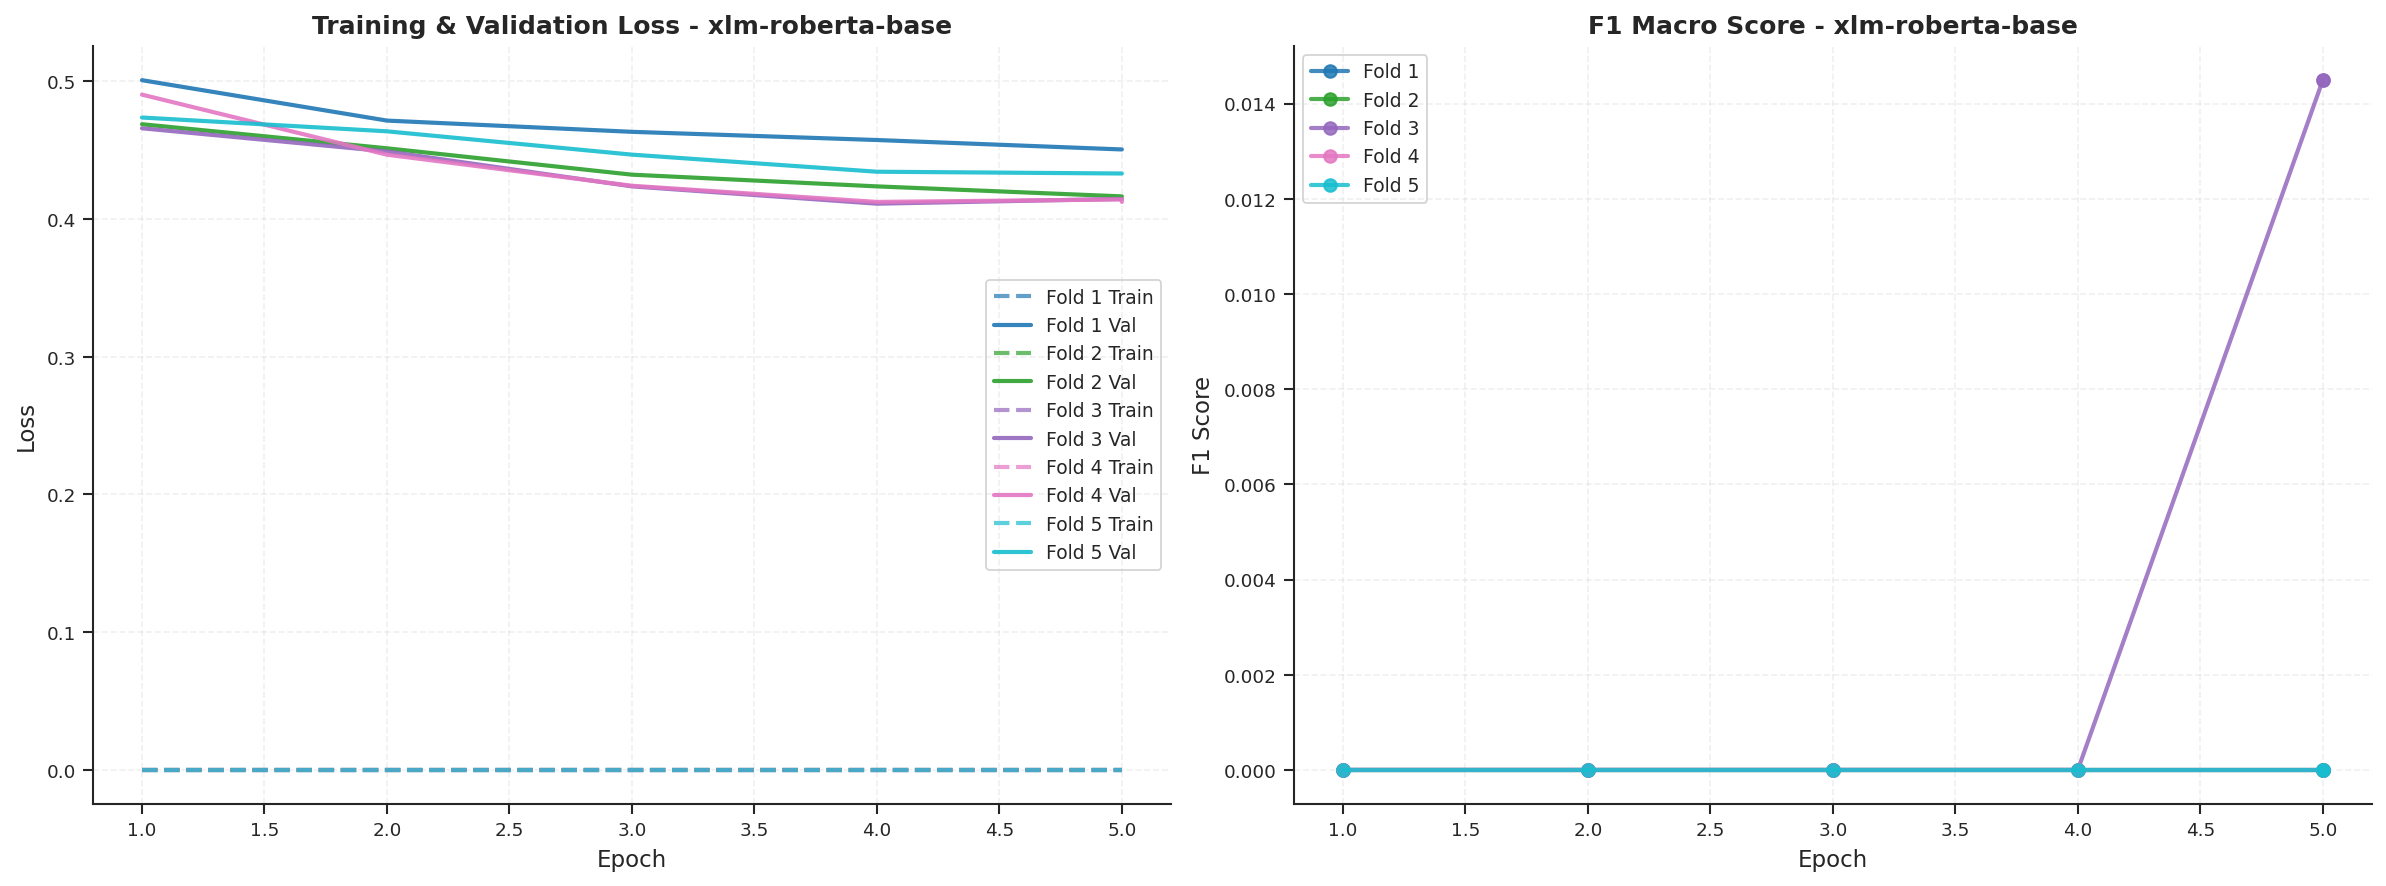


Making Weighted Ensemble Predictions

Getting predictions from Fold 1 (F1: 0.0000)...


Getting predictions from Fold 2 (F1: 0.0000)...


Getting predictions from Fold 3 (F1: 0.0145)...


Getting predictions from Fold 4 (F1: 0.0000)...


Getting predictions from Fold 5 (F1: 0.0000)...



Ensemble weights: [0.21876191 0.20221209 0.16848233 0.20026018 0.21028349]

✓ Best model prepared (Fold 3)
✓ F1 Score: 0.0145
✓ Combined Score: -0.0520
✓ Prepared Fold 1
✓ Prepared Fold 2
✓ Prepared Fold 3
✓ Prepared Fold 4
✓ Prepared Fold 5

Compressing all models...

✓ All models saved to compressed file:
  /content/drive/MyDrive/Colab Notebooks/nlp/subtask3_eng_xlm-roberta-base.zip
  Model: xlm-roberta-base
  Language: english


✓ Saved predictions to subtask_3/pred_eng.csv

Sample predictions:
                                     id  stereotype  vilification  \
0  eng_f66ca14d60851371f9720aaf4ccd9b58           0             0   
1  eng_3a489aa7fed9726aa8d3d4fe74c57efb           0             0   
2  eng_95770ff547ea5e48b0be00f385986483           0             0   
3  eng_2048ae6f9aa261c48e6d777bcc5b38bf           0             0   
4  eng_07781aa88e61e7c0a996abd1e5ea3a20           0             0   
5  eng_153d96f9dc27f0602c927223404d94b5           0             0   
6  eng_4ab5a4

In [ ]:
if __name__ == "__main__":
    main()

# ============================================
# USAGE EXAMPLES
# ============================================

# Example 1: Train new model (default)
# if __name__ == "__main__":
#     main()

# Example 2: Load saved model and make predictions (single best model)
# if __name__ == "__main__":
#     predictions = predict_with_saved_model(
#         test_csv_path='subtask3/dev/eng.csv',
#         language='english',
#         model_name='twitter-roberta-base-2022-154m',
#         output_csv='new_predictions.csv',
#         threshold=0.5
#     )

# Example 3: Load ALL fold models and make ensemble predictions
# if __name__ == "__main__":
#     predictions = ensemble_predict_with_saved_models(
#         test_csv_path='subtask3/dev/eng.csv',
#         language='english',
#         model_name='twitter-roberta-base-2022-154m',
#         method='weighted_combined',
#         output_csv='ensemble_predictions.csv',
#         threshold=0.5
#     )

# Example 4: Continue training a saved model
# if __name__ == "__main__":
#     trainer = continue_training(
#         train_csv_path='subtask3/train/eng.csv',
#         language='english',
#         model_name='twitter-roberta-base-2022-154m',
#         additional_epochs=5
#     )

# Example 5: Load model for custom use
# if __name__ == "__main__":
#     model, tokenizer, model_info = load_saved_model('english', 'twitter-roberta-base-2022-154m')
#     print(f"Model info: {model_info}")

# Example 6: Load all fold models for custom ensemble
# if __name__ == "__main__":
#     fold_models = load_all_fold_models('english', 'twitter-roberta-base-2022-154m')
#     print(f"Loaded {len(fold_models)} models")

In [ ]:
# import os
# import zipfile
# import json
# import numpy as np
# import pandas as pd
# import torch
# from sklearn.model_selection import StratifiedKFold, train_test_split
# from sklearn.metrics import f1_score
# from transformers import (
#     AutoTokenizer,
#     AutoModelForSequenceClassification,
#     AutoConfig,
#     Trainer,
#     TrainingArguments,
#     TrainerCallback,
#     DataCollatorWithPadding
# )

# ============================================
# Configuration
# ============================================
CONFIG = {
    'english': {#microsoft/deberta-v3-base
        'model_name': 'FacebookAI/xlm-roberta-large',
        'train_file': 'subtask3/train/eng.csv',
        'test_file': 'subtask3/dev/eng.csv',
        'output_name': 'eng'
    },
    'swahili': {
        'model_name': 'Davlan/afro-xlmr-large',
        'train_file': 'subtask3/train/swa.csv',
        'test_file': 'subtask3/dev/swa.csv',
        'output_name': 'swa'
    }
}

LABEL_COLUMNS = ['stereotype', 'vilification', 'dehumanization',
                 'extreme_language', 'lack_of_empathy', 'invalidation']

# Select language
LANGUAGE = 'english'
config = CONFIG[LANGUAGE]

In [ ]:
# @title Multiclass Simplified - 5 Epochs



class Subtask3Dataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding=False,
            max_length=self.max_length,
            return_tensors='pt'
        )

        item = {key: encoding[key].squeeze() for key in encoding.keys()}
        item['labels'] = torch.tensor(label, dtype=torch.float)
        return item

class Subtask3TestDataset(torch.utils.data.Dataset):
    def __init__(self, texts, tokenizer, max_length=128):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx]) if pd.notna(self.texts[idx]) else ""
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding=False,
            max_length=self.max_length,
            return_tensors='pt'
        )

        item = {key: encoding[key].squeeze(0) for key in encoding.keys()}
        return item

# ============================================
# Enhanced Monitoring Callback
# ============================================
class EnhancedMonitoringCallback(TrainerCallback):
    """Callback to monitor and log F1, train loss, and eval loss"""
    def __init__(self):
        self.best_f1 = -float('inf')
        self.best_eval_loss = float('inf')
        self.best_train_loss = float('inf')
        self.history = {
            'epoch': [],
            'train_loss': [],
            'eval_loss': [],
            'eval_f1': []
        }

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs and 'loss' in logs:
            if logs['loss'] < self.best_train_loss:
                self.best_train_loss = logs['loss']

    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        if metrics is not None:
            epoch = state.epoch
            train_loss = metrics.get('train_loss', state.log_history[-1].get('loss', 0) if state.log_history else 0)
            eval_loss = metrics.get('eval_loss', 0)
            eval_f1 = metrics.get('eval_f1_macro', 0)

            self.history['epoch'].append(epoch)
            self.history['train_loss'].append(train_loss)
            self.history['eval_loss'].append(eval_loss)
            self.history['eval_f1'].append(eval_f1)

            if eval_f1 > self.best_f1:
                self.best_f1 = eval_f1
            if eval_loss < self.best_eval_loss:
                self.best_eval_loss = eval_loss

            print(f"\n{'='*70}")
            print(f"Epoch {epoch:.1f} Metrics:")
            print(f"{'='*70}")
            print(f"  F1 Score:        {eval_f1:.4f} (Best: {self.best_f1:.4f})")
            print(f"  Eval Loss:       {eval_loss:.4f} (Best: {self.best_eval_loss:.4f})")
            print(f"  Train Loss:      {train_loss:.4f} (Best: {self.best_train_loss:.4f})")

            if eval_f1 == self.best_f1:
                print(f"  ✓ NEW BEST F1!")
            if eval_loss == self.best_eval_loss:
                print(f"  ✓ NEW BEST EVAL LOSS!")
            print(f"{'='*70}\n")

# ============================================
# Compute Metrics for Multi-Label
# ============================================
def compute_metrics_multilabel(p):
    """Compute macro F1 for multi-label classification"""
    probs = torch.sigmoid(torch.from_numpy(p.predictions))
    preds = (probs > 0.5).int().numpy()
    return {'f1_macro': f1_score(p.label_ids, preds, average='macro', zero_division=0)}

# ============================================
# Create Stratification Key for Multi-Label
# ============================================
def create_stratify_key(df, label_columns):
    """Create a stratification key for multi-label data"""
    return df[label_columns].apply(lambda row: '_'.join(row.astype(str)), axis=1)

# ============================================
# K-Fold Cross-Validation with Simplified Training
# ============================================
def train_kfold_cv(train_df, model_name, label_columns, n_splits=5, seed=42):
    """Train model using K-Fold Cross-Validation for multi-label classification"""

    # Create stratification key
    train_df['stratify_key'] = create_stratify_key(train_df, label_columns)

    # Check for rare combinations
    value_counts = train_df['stratify_key'].value_counts()
    valid_keys = value_counts[value_counts >= 2].index

    # Handle rare combinations
    train_df['stratify_col'] = train_df['stratify_key'].apply(
        lambda x: x if x in valid_keys else 'rare'
    )

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    fold_models = []
    fold_scores = []
    fold_metrics = []

    tokenizer = AutoTokenizer.from_pretrained(model_name)

    print(f"\n{'='*70}")
    print(f"Starting {n_splits}-Fold Cross-Validation")
    print(f"Model: {model_name}")
    print(f"Total samples: {len(train_df)}")
    print(f"Task: Multi-Label Classification ({len(label_columns)} labels)")
    print(f"Training: Simplified Fast Training (5 Epochs)")
    print(f"{'='*70}\n")

    for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df['stratify_col'])):
        print(f"\n{'='*70}")
        print(f"FOLD {fold + 1}/{n_splits}")
        print(f"{'='*70}")

        train_fold = train_df.iloc[train_idx]
        val_fold = train_df.iloc[val_idx]

        print(f"Train size: {len(train_fold)}, Val size: {len(val_fold)}")

        # Create datasets
        train_dataset = Subtask3Dataset(
            train_fold['text'].tolist(),
            train_fold[label_columns].values.tolist(),
            tokenizer
        )
        val_dataset = Subtask3Dataset(
            val_fold['text'].tolist(),
            val_fold[label_columns].values.tolist(),
            tokenizer
        )

        model_config = AutoConfig.from_pretrained(model_name)
        model_config.hidden_dropout_prob = 0.1  # Lower for faster training
        model_config.attention_probs_dropout_prob = 0.1
        model_config.classifier_dropout = 0.1
        model_config.num_labels = len(label_columns)
        model_config.problem_type = "multi_label_classification"

        # Initialize model with dropout
        model = AutoModelForSequenceClassification.from_pretrained(
            model_name,
            config=model_config,
            ignore_mismatched_sizes=True
        )

        training_args = TrainingArguments(
            output_dir=f"/content/outputs/fold_{fold+1}",
            num_train_epochs=5,  # 5 epochs as requested
            learning_rate=3e-5,  # Standard learning rate
            lr_scheduler_type="linear",
            per_device_train_batch_size=32,
            per_device_eval_batch_size=32,
            weight_decay=0.01,  # Basic regularization
            eval_strategy="epoch",
            save_strategy="epoch",
            logging_steps=50,
            save_total_limit=1,  # Only keep best model
            load_best_model_at_end=True,
            metric_for_best_model="f1_macro",  # Simple F1 metric
            greater_is_better=True,
            fp16=True,  # Speed up training
            disable_tqdm=False,
            report_to="none"
        )

        monitoring_callback = EnhancedMonitoringCallback()

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            compute_metrics=compute_metrics_multilabel,
            data_collator=DataCollatorWithPadding(tokenizer),
            callbacks=[monitoring_callback]
        )

        # Train
        print(f"\nTraining Fold {fold + 1}...")
        trainer.train()

        # Final evaluation
        eval_results = trainer.evaluate()
        fold_score = eval_results['eval_f1_macro']
        fold_eval_loss = eval_results['eval_loss']

        fold_scores.append(fold_score)
        fold_metrics.append({
            'fold': fold + 1,
            'f1': fold_score,
            'eval_loss': fold_eval_loss,
            'combined_score': fold_score,  # Use F1 as combined score for simplicity
            'best_f1': monitoring_callback.best_f1,
            'best_eval_loss': monitoring_callback.best_eval_loss,
            'best_train_loss': monitoring_callback.best_train_loss
        })

        print(f"\n{'='*70}")
        print(f"Fold {fold + 1} Final Results:")
        print(f"{'='*70}")
        print(f"  F1 Score:       {fold_score:.4f}")
        print(f"  Eval Loss:      {fold_eval_loss:.4f}")
        print(f"{'='*70}")

        # Save model info
        fold_models.append({
            'model': model,
            'tokenizer': tokenizer,
            'score': fold_score,
            'eval_loss': fold_eval_loss,
            'combined_score': fold_score,  # Use F1 as combined score
            'fold': fold + 1,
            'history': monitoring_callback.history
        })

    # Print summary
    print(f"\n{'='*70}")
    print(f"CROSS-VALIDATION SUMMARY")
    print(f"{'='*70}")
    print(f"\nPer-Fold Results:")
    print(f"{'Fold':<8} {'F1 Score':<12} {'Eval Loss':<12} {'Combined':<12}")
    print(f"{'-'*50}")
    for metrics in fold_metrics:
        print(f"{metrics['fold']:<8} {metrics['f1']:<12.4f} {metrics['eval_loss']:<12.4f} {metrics['combined_score']:<12.4f}")

    print(f"\nAggregate Statistics:")
    print(f"  Mean F1:       {np.mean(fold_scores):.4f} ± {np.std(fold_scores):.4f}")
    print(f"  Mean Eval Loss:{np.mean([m['eval_loss'] for m in fold_metrics]):.4f} ± {np.std([m['eval_loss'] for m in fold_metrics]):.4f}")
    print(f"  Mean Combined: {np.mean([m['combined_score'] for m in fold_metrics]):.4f} ± {np.std([m['combined_score'] for m in fold_metrics]):.4f}")
    print(f"{'='*70}\n")

    # Plot results
    plot_all_folds(fold_models, config['model_name'], LANGUAGE)

    return fold_models, fold_metrics

# ============================================
# Plotting Function
# ============================================
def plot_all_folds(fold_models, model_name, language):
    """Plot training history for all folds with complementary colors"""
    import matplotlib.pyplot as plt

    cfg = CONFIG[language]
    short_model_name = cfg['model_name'].split('/')[-1]

    n_folds = len(fold_models)
    colors = plt.cm.tab10(np.linspace(0, 0.9, n_folds))

    fig = plt.figure(figsize=(16, 6))
    mosaic = [['losses', 'f1']]
    axes = fig.subplot_mosaic(mosaic)

    # Left plot: Losses for all folds
    for idx, fold_model in enumerate(fold_models):
        history = fold_model['history']
        fold_num = fold_model['fold']
        color = colors[idx]

        axes['losses'].plot(history['epoch'], history['train_loss'],
                           label=f'Fold {fold_num} Train',
                           alpha=0.7,
                           linestyle='--',
                           color=color,
                           linewidth=2)
        axes['losses'].plot(history['epoch'], history['eval_loss'],
                           label=f'Fold {fold_num} Val',
                           alpha=0.9,
                           color=color,
                           linewidth=2)

    axes['losses'].set_xlabel('Epoch', fontsize=11)
    axes['losses'].set_ylabel('Loss', fontsize=11)
    axes['losses'].set_title(f'Training & Validation Loss - {short_model_name}', fontsize=12, fontweight='bold')
    axes['losses'].legend(fontsize=9, framealpha=0.9)
    axes['losses'].grid(True, alpha=0.3, linestyle='--')

    # Right plot: F1 scores for all folds
    for idx, fold_model in enumerate(fold_models):
        history = fold_model['history']
        fold_num = fold_model['fold']
        color = colors[idx]

        axes['f1'].plot(history['epoch'], history['eval_f1'],
                       label=f'Fold {fold_num}',
                       marker='o',
                       alpha=0.85,
                       color=color,
                       linewidth=2,
                       markersize=6)

    axes['f1'].set_xlabel('Epoch', fontsize=11)
    axes['f1'].set_ylabel('F1 Score', fontsize=11)
    axes['f1'].set_title(f'F1 Macro Score - {short_model_name}', fontsize=12, fontweight='bold')
    axes['f1'].legend(fontsize=9, framealpha=0.9)
    axes['f1'].grid(True, alpha=0.3, linestyle='--')

    plt.tight_layout()
    plot_filename = f'subtask3_{cfg["output_name"]}_{short_model_name}.pdf'
    plt.savefig(plot_filename, dpi=200, format='pdf')
    print(f"\n✓ Plot saved to: {plot_filename}")
    plt.show()

# ============================================
# Ensemble Prediction for Multi-Label
# ============================================
def ensemble_predict_multilabel(fold_models, test_dataset, method='weighted', threshold=0.5):
    """Make ensemble predictions for multi-label classification"""
    all_predictions = []
    weights = []

    for i, fold_model in enumerate(fold_models):
        print(f"Getting predictions from Fold {i+1} (F1: {fold_model['score']:.4f})...")

        model = fold_model['model']
        tokenizer = fold_model['tokenizer']

        trainer = Trainer(
            model=model,
            data_collator=DataCollatorWithPadding(tokenizer)
        )

        predictions = trainer.predict(test_dataset)
        probs = torch.sigmoid(torch.tensor(predictions.predictions))
        all_predictions.append(probs.numpy())

        if method == 'weighted':
            weights.append(fold_model['score'])
        elif method == 'weighted_combined':
            weights.append(fold_model['combined_score'])
        else:
            weights.append(1.0)

    # Normalize weights
    weights = np.array(weights)
    weights = weights / weights.sum()

    print(f"\nEnsemble weights: {weights}")

    # Weighted average of probabilities
    weighted_probs = np.zeros_like(all_predictions[0])
    for pred, weight in zip(all_predictions, weights):
        weighted_probs += pred * weight

    # Apply threshold
    final_predictions = (weighted_probs > threshold).astype(int)

    return final_predictions

# ============================================
# Save Models in Compressed Format
# ============================================
def save_fold_models(fold_models, fold_metrics, language):
    """Save all fold models and metrics in a single compressed file"""
    cfg = CONFIG[language]
    short_model_name = cfg['model_name'].split('/')[-1]

    # Create temporary directory for models
    temp_dir = f"/content/temp_models_{cfg['output_name']}"
    os.makedirs(temp_dir, exist_ok=True)

    # Save best model
    best_fold_idx = np.argmax([m['combined_score'] for m in fold_metrics])
    best_fold_model = fold_models[best_fold_idx]

    best_model_dir = os.path.join(temp_dir, "best_model")
    os.makedirs(best_model_dir, exist_ok=True)
    best_fold_model['model'].save_pretrained(best_model_dir)
    best_fold_model['tokenizer'].save_pretrained(best_model_dir)

    print(f"\n✓ Best model prepared (Fold {best_fold_model['fold']})")
    print(f"✓ F1 Score: {best_fold_model['score']:.4f}")
    print(f"✓ Combined Score: {best_fold_model['combined_score']:.4f}")

    # Save all fold models
    for fold_model in fold_models:
        fold_dir = os.path.join(temp_dir, f"fold_{fold_model['fold']}")
        os.makedirs(fold_dir, exist_ok=True)
        fold_model['model'].save_pretrained(fold_dir)
        fold_model['tokenizer'].save_pretrained(fold_dir)
        print(f"✓ Prepared Fold {fold_model['fold']}")

    # Save metrics
    metrics_path = os.path.join(temp_dir, "fold_metrics.json")
    with open(metrics_path, 'w') as f:
        json.dump(fold_metrics, f, indent=2)

    # Save model info
    model_info = {
        'language': language,
        'model_name': cfg['model_name'],
        'short_model_name': short_model_name,
        'best_fold': best_fold_model['fold'],
        'best_f1': best_fold_model['score'],
        'best_combined_score': best_fold_model['combined_score'],
        'n_folds': len(fold_models),
        'label_columns': LABEL_COLUMNS
    }
    info_path = os.path.join(temp_dir, "model_info.json")
    with open(info_path, 'w') as f:
        json.dump(model_info, f, indent=2)

    # Compress everything
    zip_filename = f"subtask3_{cfg['output_name']}_{short_model_name}.zip"
    final_path = f"/content/drive/MyDrive/Colab Notebooks/nlp/{zip_filename}"

    print(f"\nCompressing all models...")
    with zipfile.ZipFile(final_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(temp_dir):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, temp_dir)
                zipf.write(file_path, arcname)

    # Clean up temp directory
    import shutil
    shutil.rmtree(temp_dir)

    print(f"\n{'='*70}")
    print(f"✓ All models saved to compressed file:")
    print(f"  {final_path}")
    print(f"  Model: {short_model_name}")
    print(f"  Language: {language}")
    print(f"{'='*70}\n")

# ============================================
# Load and Prediction Functions (from original code)
# ============================================
def load_saved_model(language='english', model_name=None):
    """Load the best saved model from compressed file"""
    cfg = CONFIG[language]

    if model_name is None:
        short_model_name = cfg['model_name'].split('/')[-1]
    else:
        short_model_name = model_name.split('/')[-1] if '/' in model_name else model_name

    zip_path = f"/content/drive/MyDrive/Colab Notebooks/nlp/subtask3_{cfg['output_name']}_{short_model_name}.zip"

    print(f"Loading model from: {zip_path}")

    temp_extract_dir = f"/content/temp_extract_{cfg['output_name']}"

    with zipfile.ZipFile(zip_path, 'r') as zipf:
        zipf.extractall(temp_extract_dir)

    with open(os.path.join(temp_extract_dir, "model_info.json"), 'r') as f:
        model_info = json.load(f)

    best_model_dir = os.path.join(temp_extract_dir, "best_model")
    model = AutoModelForSequenceClassification.from_pretrained(best_model_dir)
    tokenizer = AutoTokenizer.from_pretrained(best_model_dir)

    print(f"✓ Model loaded successfully!")
    print(f"  Model: {model_info['short_model_name']}")
    print(f"  Best Fold: {model_info['best_fold']}")
    print(f"  F1 Score: {model_info['best_f1']:.4f}")

    return model, tokenizer, model_info

def load_all_fold_models(language='english', model_name=None):
    """Load all saved fold models from compressed file for ensemble prediction"""
    cfg = CONFIG[language]

    if model_name is None:
        short_model_name = cfg['model_name'].split('/')[-1]
    else:
        short_model_name = model_name.split('/')[-1] if '/' in model_name else model_name

    zip_path = f"/content/drive/MyDrive/Colab Notebooks/nlp/subtask3_{cfg['output_name']}_{short_model_name}.zip"

    print(f"\nLoading all fold models from: {zip_path}")

    temp_extract_dir = f"/content/temp_extract_{cfg['output_name']}"

    with zipfile.ZipFile(zip_path, 'r') as zipf:
        zipf.extractall(temp_extract_dir)

    with open(os.path.join(temp_extract_dir, "model_info.json"), 'r') as f:
        model_info = json.load(f)

    with open(os.path.join(temp_extract_dir, "fold_metrics.json"), 'r') as f:
        fold_metrics = json.load(f)

    n_folds = model_info['n_folds']
    fold_models = []

    print(f"Loading {n_folds} fold models for {language} ({short_model_name})...")

    for fold_num in range(1, n_folds + 1):
        fold_dir = os.path.join(temp_extract_dir, f"fold_{fold_num}")

        print(f"  Loading Fold {fold_num}...")

        model = AutoModelForSequenceClassification.from_pretrained(fold_dir)
        tokenizer = AutoTokenizer.from_pretrained(fold_dir)

        fold_metric = fold_metrics[fold_num - 1]

        fold_models.append({
            'model': model,
            'tokenizer': tokenizer,
            'fold': fold_num,
            'score': fold_metric['f1'],
            'eval_loss': fold_metric['eval_loss'],
            'combined_score': fold_metric['combined_score']
        })

        print(f"  ✓ Fold {fold_num} loaded (F1: {fold_metric['f1']:.4f}, Loss: {fold_metric['eval_loss']:.4f})")

    print(f"\n✓ All {n_folds} models loaded successfully!")

    return fold_models

def predict_with_saved_model(test_csv_path, language='english', model_name=None,
                             output_csv='predictions.csv', threshold=0.5):
    """Make predictions using saved best model"""
    model, tokenizer, model_info = load_saved_model(language, model_name)

    test = pd.read_csv(test_csv_path)
    print(f"Test size: {len(test)}")

    test_dataset = Subtask3TestDataset(test['text'].tolist(), tokenizer)

    trainer = Trainer(
        model=model,
        data_collator=DataCollatorWithPadding(tokenizer)
    )

    print("Making predictions...")
    predictions = trainer.predict(test_dataset)
    probs = torch.sigmoid(torch.tensor(predictions.predictions))
    predicted_labels = (probs > threshold).int().numpy()

    label_cols = model_info['label_columns']
    results_df = pd.DataFrame({'id': test['id']})
    for i, col in enumerate(label_cols):
        results_df[col] = predicted_labels[:, i]

    results_df.to_csv(output_csv, index=False)

    print(f"✓ Predictions saved to: {output_csv}")
    print(f"\nSample predictions:")
    print(results_df.head())
    print(f"\nPrediction distribution:")
    print(results_df[label_cols].sum())

    return results_df

def ensemble_predict_with_saved_models(test_csv_path, language='english', model_name=None,
                                       method='weighted_combined',
                                       output_csv='ensemble_predictions.csv',
                                       threshold=0.5):
    """Make ensemble predictions using all saved fold models"""
    fold_models = load_all_fold_models(language, model_name)

    test = pd.read_csv(test_csv_path)
    print(f"\nTest size: {len(test)}")

    tokenizer = fold_models[0]['tokenizer']
    test_dataset = Subtask3TestDataset(test['text'].tolist(), tokenizer)

    print(f"\nMaking ensemble predictions with method: {method}")
    final_predictions = ensemble_predict_multilabel(fold_models, test_dataset, method=method, threshold=threshold)

    results_df = pd.DataFrame({'id': test['id']})
    for i, col in enumerate(LABEL_COLUMNS):
        results_df[col] = final_predictions[:, i]

    results_df.to_csv(output_csv, index=False)

    print(f"\n✓ Ensemble predictions saved to: {output_csv}")
    print(f"\nSample predictions:")
    print(results_df.head(10))
    print(f"\nPrediction distribution:")
    print(results_df[LABEL_COLUMNS].sum())

    return results_df

# ============================================
# Main Training Pipeline
# ============================================
def main():
    print(f"Loading data for {LANGUAGE}...")
    train = pd.read_csv(config['train_file'])
    test = pd.read_csv(config['test_file'])

    print(f"Train size: {len(train)}")
    print(f"Test size: {len(test)}")
    print(f"\nLabel distribution:")
    print(train[LABEL_COLUMNS].sum())

    # Train with K-Fold CV
    fold_models, fold_metrics = train_kfold_cv(
        train,
        config['model_name'],
        LABEL_COLUMNS,
        n_splits=5,
        seed=42
    )




    # Create test dataset
    tokenizer = AutoTokenizer.from_pretrained(config['model_name'])
    test_dataset = Subtask3TestDataset(test['text'].tolist(), tokenizer)

    # Ensemble predictions
    print("\n" + "="*70)
    print("Making Weighted Ensemble Predictions")
    print("="*70 + "\n")

    final_predictions = ensemble_predict_multilabel(
        fold_models,
        test_dataset,
        method='weighted_combined',
        threshold=0.5
    )



    # Save predictions
    results_df = pd.DataFrame({'id': test['id']})
    for i, col in enumerate(LABEL_COLUMNS):
        results_df[col] = final_predictions[:, i]

    os.makedirs('subtask_3', exist_ok=True)
    csv_path = f'subtask_3/pred_{config["output_name"]}.csv'
    results_df.to_csv(csv_path, index=False)

    print(f"\n✓ Saved predictions to {csv_path}")
    print(f"\nSample predictions:")
    print(results_df.head(10))
    print(f"\nPrediction distribution:")
    print(results_df[LABEL_COLUMNS].sum())

    # Save models AFTER predictions
    print("\n" + "="*70)
    print("Saving Fold Models")
    print("="*70 + "\n")
    # save_fold_models(fold_models, fold_metrics, LANGUAGE)

    # Compress predictions
    zip_filename = f'subtask_3_{config["output_name"]}_ensemble.zip'
    with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk('subtask_3'):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.join(os.path.basename(root), file)
                zipf.write(file_path, arcname)

    print(f"✓ Created compressed file: {zip_filename}")

    # Save models
    save_fold_models(fold_models, fold_metrics, LANGUAGE)



Loading data for swahili...
Train size: 6991
Test size: 349

Label distribution:
stereotype          2775
vilification        2883
dehumanization       893
extreme_language    1673
lack_of_empathy     2080
invalidation        1637
dtype: int64


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]


Starting 5-Fold Cross-Validation
Model: FacebookAI/xlm-roberta-base
Total samples: 6991
Task: Multi-Label Classification (6 labels)
Training: Simplified Fast Training (5 Epochs)


FOLD 1/5
Train size: 5592, Val size: 1399


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training Fold 1...


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.562700,0.581525,0.125198
2,0.527000,0.499454,0.252901
3,0.492300,0.491736,0.432507
4,0.443500,0.489240,0.406313
5,0.441300,0.488193,0.468752



Epoch 1.0 Metrics:
  F1 Score:        0.1252 (Best: 0.1252)
  Eval Loss:       0.5815 (Best: 0.5815)
  Train Loss:      0.0000 (Best: 0.5627)
  ✓ NEW BEST F1!
  ✓ NEW BEST EVAL LOSS!


Epoch 2.0 Metrics:
  F1 Score:        0.2529 (Best: 0.2529)
  Eval Loss:       0.4995 (Best: 0.4995)
  Train Loss:      0.0000 (Best: 0.4952)
  ✓ NEW BEST F1!
  ✓ NEW BEST EVAL LOSS!


Epoch 3.0 Metrics:
  F1 Score:        0.4325 (Best: 0.4325)
  Eval Loss:       0.4917 (Best: 0.4917)
  Train Loss:      0.0000 (Best: 0.4851)
  ✓ NEW BEST F1!
  ✓ NEW BEST EVAL LOSS!


Epoch 4.0 Metrics:
  F1 Score:        0.4063 (Best: 0.4325)
  Eval Loss:       0.4892 (Best: 0.4892)
  Train Loss:      0.0000 (Best: 0.4435)
  ✓ NEW BEST EVAL LOSS!


Epoch 5.0 Metrics:
  F1 Score:        0.4688 (Best: 0.4688)
  Eval Loss:       0.4882 (Best: 0.4882)
  Train Loss:      0.0000 (Best: 0.4350)
  ✓ NEW BEST F1!
  ✓ NEW BEST EVAL LOSS!




Epoch 5.0 Metrics:
  F1 Score:        0.4688 (Best: 0.4688)
  Eval Loss:       0.4882 (Best: 0.4882)
  Train Loss:      0.0000 (Best: 0.4350)
  ✓ NEW BEST F1!
  ✓ NEW BEST EVAL LOSS!


Fold 1 Final Results:
  F1 Score:       0.4688
  Eval Loss:      0.4882

FOLD 2/5
Train size: 5593, Val size: 1398


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training Fold 2...


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.566300,0.529094,0.195486
2,0.490600,0.491611,0.336313
3,0.476200,0.477698,0.410859
4,0.444200,0.474671,0.403275
5,0.435900,0.477116,0.457568



Epoch 1.0 Metrics:
  F1 Score:        0.1955 (Best: 0.1955)
  Eval Loss:       0.5291 (Best: 0.5291)
  Train Loss:      0.0000 (Best: 0.5663)
  ✓ NEW BEST F1!
  ✓ NEW BEST EVAL LOSS!


Epoch 2.0 Metrics:
  F1 Score:        0.3363 (Best: 0.3363)
  Eval Loss:       0.4916 (Best: 0.4916)
  Train Loss:      0.0000 (Best: 0.4906)
  ✓ NEW BEST F1!
  ✓ NEW BEST EVAL LOSS!


Epoch 3.0 Metrics:
  F1 Score:        0.4109 (Best: 0.4109)
  Eval Loss:       0.4777 (Best: 0.4777)
  Train Loss:      0.0000 (Best: 0.4692)
  ✓ NEW BEST F1!
  ✓ NEW BEST EVAL LOSS!


Epoch 4.0 Metrics:
  F1 Score:        0.4033 (Best: 0.4109)
  Eval Loss:       0.4747 (Best: 0.4747)
  Train Loss:      0.0000 (Best: 0.4442)
  ✓ NEW BEST EVAL LOSS!


Epoch 5.0 Metrics:
  F1 Score:        0.4576 (Best: 0.4576)
  Eval Loss:       0.4771 (Best: 0.4747)
  Train Loss:      0.0000 (Best: 0.4282)
  ✓ NEW BEST F1!




Epoch 5.0 Metrics:
  F1 Score:        0.4576 (Best: 0.4576)
  Eval Loss:       0.4771 (Best: 0.4747)
  Train Loss:      0.0000 (Best: 0.4282)
  ✓ NEW BEST F1!


Fold 2 Final Results:
  F1 Score:       0.4576
  Eval Loss:      0.4771

FOLD 3/5
Train size: 5593, Val size: 1398


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training Fold 3...


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.553900,0.510022,0.310470
2,0.483400,0.480659,0.390321
3,0.468900,0.474568,0.474193
4,0.441300,0.467829,0.453698
5,0.425200,0.471937,0.485920



Epoch 1.0 Metrics:
  F1 Score:        0.3105 (Best: 0.3105)
  Eval Loss:       0.5100 (Best: 0.5100)
  Train Loss:      0.0000 (Best: 0.5539)
  ✓ NEW BEST F1!
  ✓ NEW BEST EVAL LOSS!


Epoch 2.0 Metrics:
  F1 Score:        0.3903 (Best: 0.3903)
  Eval Loss:       0.4807 (Best: 0.4807)
  Train Loss:      0.0000 (Best: 0.4834)
  ✓ NEW BEST F1!
  ✓ NEW BEST EVAL LOSS!


Epoch 3.0 Metrics:
  F1 Score:        0.4742 (Best: 0.4742)
  Eval Loss:       0.4746 (Best: 0.4746)
  Train Loss:      0.0000 (Best: 0.4646)
  ✓ NEW BEST F1!
  ✓ NEW BEST EVAL LOSS!


Epoch 4.0 Metrics:
  F1 Score:        0.4537 (Best: 0.4742)
  Eval Loss:       0.4678 (Best: 0.4678)
  Train Loss:      0.0000 (Best: 0.4402)
  ✓ NEW BEST EVAL LOSS!


Epoch 5.0 Metrics:
  F1 Score:        0.4859 (Best: 0.4859)
  Eval Loss:       0.4719 (Best: 0.4678)
  Train Loss:      0.0000 (Best: 0.4226)
  ✓ NEW BEST F1!




Epoch 5.0 Metrics:
  F1 Score:        0.4859 (Best: 0.4859)
  Eval Loss:       0.4719 (Best: 0.4678)
  Train Loss:      0.0000 (Best: 0.4226)
  ✓ NEW BEST F1!


Fold 3 Final Results:
  F1 Score:       0.4859
  Eval Loss:      0.4719

FOLD 4/5
Train size: 5593, Val size: 1398


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training Fold 4...


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.560200,0.523920,0.326879
2,0.494700,0.516362,0.440114
3,0.472300,0.470976,0.437565
4,0.450700,0.471547,0.470369
5,0.435100,0.472443,0.482022



Epoch 1.0 Metrics:
  F1 Score:        0.3269 (Best: 0.3269)
  Eval Loss:       0.5239 (Best: 0.5239)
  Train Loss:      0.0000 (Best: 0.5602)
  ✓ NEW BEST F1!
  ✓ NEW BEST EVAL LOSS!


Epoch 2.0 Metrics:
  F1 Score:        0.4401 (Best: 0.4401)
  Eval Loss:       0.5164 (Best: 0.5164)
  Train Loss:      0.0000 (Best: 0.4947)
  ✓ NEW BEST F1!
  ✓ NEW BEST EVAL LOSS!


Epoch 3.0 Metrics:
  F1 Score:        0.4376 (Best: 0.4401)
  Eval Loss:       0.4710 (Best: 0.4710)
  Train Loss:      0.0000 (Best: 0.4723)
  ✓ NEW BEST EVAL LOSS!


Epoch 4.0 Metrics:
  F1 Score:        0.4704 (Best: 0.4704)
  Eval Loss:       0.4715 (Best: 0.4710)
  Train Loss:      0.0000 (Best: 0.4495)
  ✓ NEW BEST F1!


Epoch 5.0 Metrics:
  F1 Score:        0.4820 (Best: 0.4820)
  Eval Loss:       0.4724 (Best: 0.4710)
  Train Loss:      0.0000 (Best: 0.4245)
  ✓ NEW BEST F1!




Epoch 5.0 Metrics:
  F1 Score:        0.4820 (Best: 0.4820)
  Eval Loss:       0.4724 (Best: 0.4710)
  Train Loss:      0.0000 (Best: 0.4245)
  ✓ NEW BEST F1!


Fold 4 Final Results:
  F1 Score:       0.4820
  Eval Loss:      0.4724

FOLD 5/5
Train size: 5593, Val size: 1398


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training Fold 5...


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.560900,0.545302,0.305210
2,0.494200,0.487755,0.406359
3,0.478100,0.481232,0.466508
4,0.436800,0.481809,0.485987
5,0.415900,0.487494,0.505357



Epoch 1.0 Metrics:
  F1 Score:        0.3052 (Best: 0.3052)
  Eval Loss:       0.5453 (Best: 0.5453)
  Train Loss:      0.0000 (Best: 0.5609)
  ✓ NEW BEST F1!
  ✓ NEW BEST EVAL LOSS!


Epoch 2.0 Metrics:
  F1 Score:        0.4064 (Best: 0.4064)
  Eval Loss:       0.4878 (Best: 0.4878)
  Train Loss:      0.0000 (Best: 0.4942)
  ✓ NEW BEST F1!
  ✓ NEW BEST EVAL LOSS!


Epoch 3.0 Metrics:
  F1 Score:        0.4665 (Best: 0.4665)
  Eval Loss:       0.4812 (Best: 0.4812)
  Train Loss:      0.0000 (Best: 0.4640)
  ✓ NEW BEST F1!
  ✓ NEW BEST EVAL LOSS!


Epoch 4.0 Metrics:
  F1 Score:        0.4860 (Best: 0.4860)
  Eval Loss:       0.4818 (Best: 0.4812)
  Train Loss:      0.0000 (Best: 0.4368)
  ✓ NEW BEST F1!


Epoch 5.0 Metrics:
  F1 Score:        0.5054 (Best: 0.5054)
  Eval Loss:       0.4875 (Best: 0.4812)
  Train Loss:      0.0000 (Best: 0.4159)
  ✓ NEW BEST F1!




Epoch 5.0 Metrics:
  F1 Score:        0.5054 (Best: 0.5054)
  Eval Loss:       0.4875 (Best: 0.4812)
  Train Loss:      0.0000 (Best: 0.4159)
  ✓ NEW BEST F1!


Fold 5 Final Results:
  F1 Score:       0.5054
  Eval Loss:      0.4875

CROSS-VALIDATION SUMMARY

Per-Fold Results:
Fold     F1 Score     Eval Loss    Combined    
--------------------------------------------------
1        0.4688       0.4882       0.4688      
2        0.4576       0.4771       0.4576      
3        0.4859       0.4719       0.4859      
4        0.4820       0.4724       0.4820      
5        0.5054       0.4875       0.5054      

Aggregate Statistics:
  Mean F1:       0.4799 ± 0.0162
  Mean Eval Loss:0.4794 ± 0.0071
  Mean Combined: 0.4799 ± 0.0162


✓ Plot saved to: subtask3_swa_xlm-roberta-base.pdf


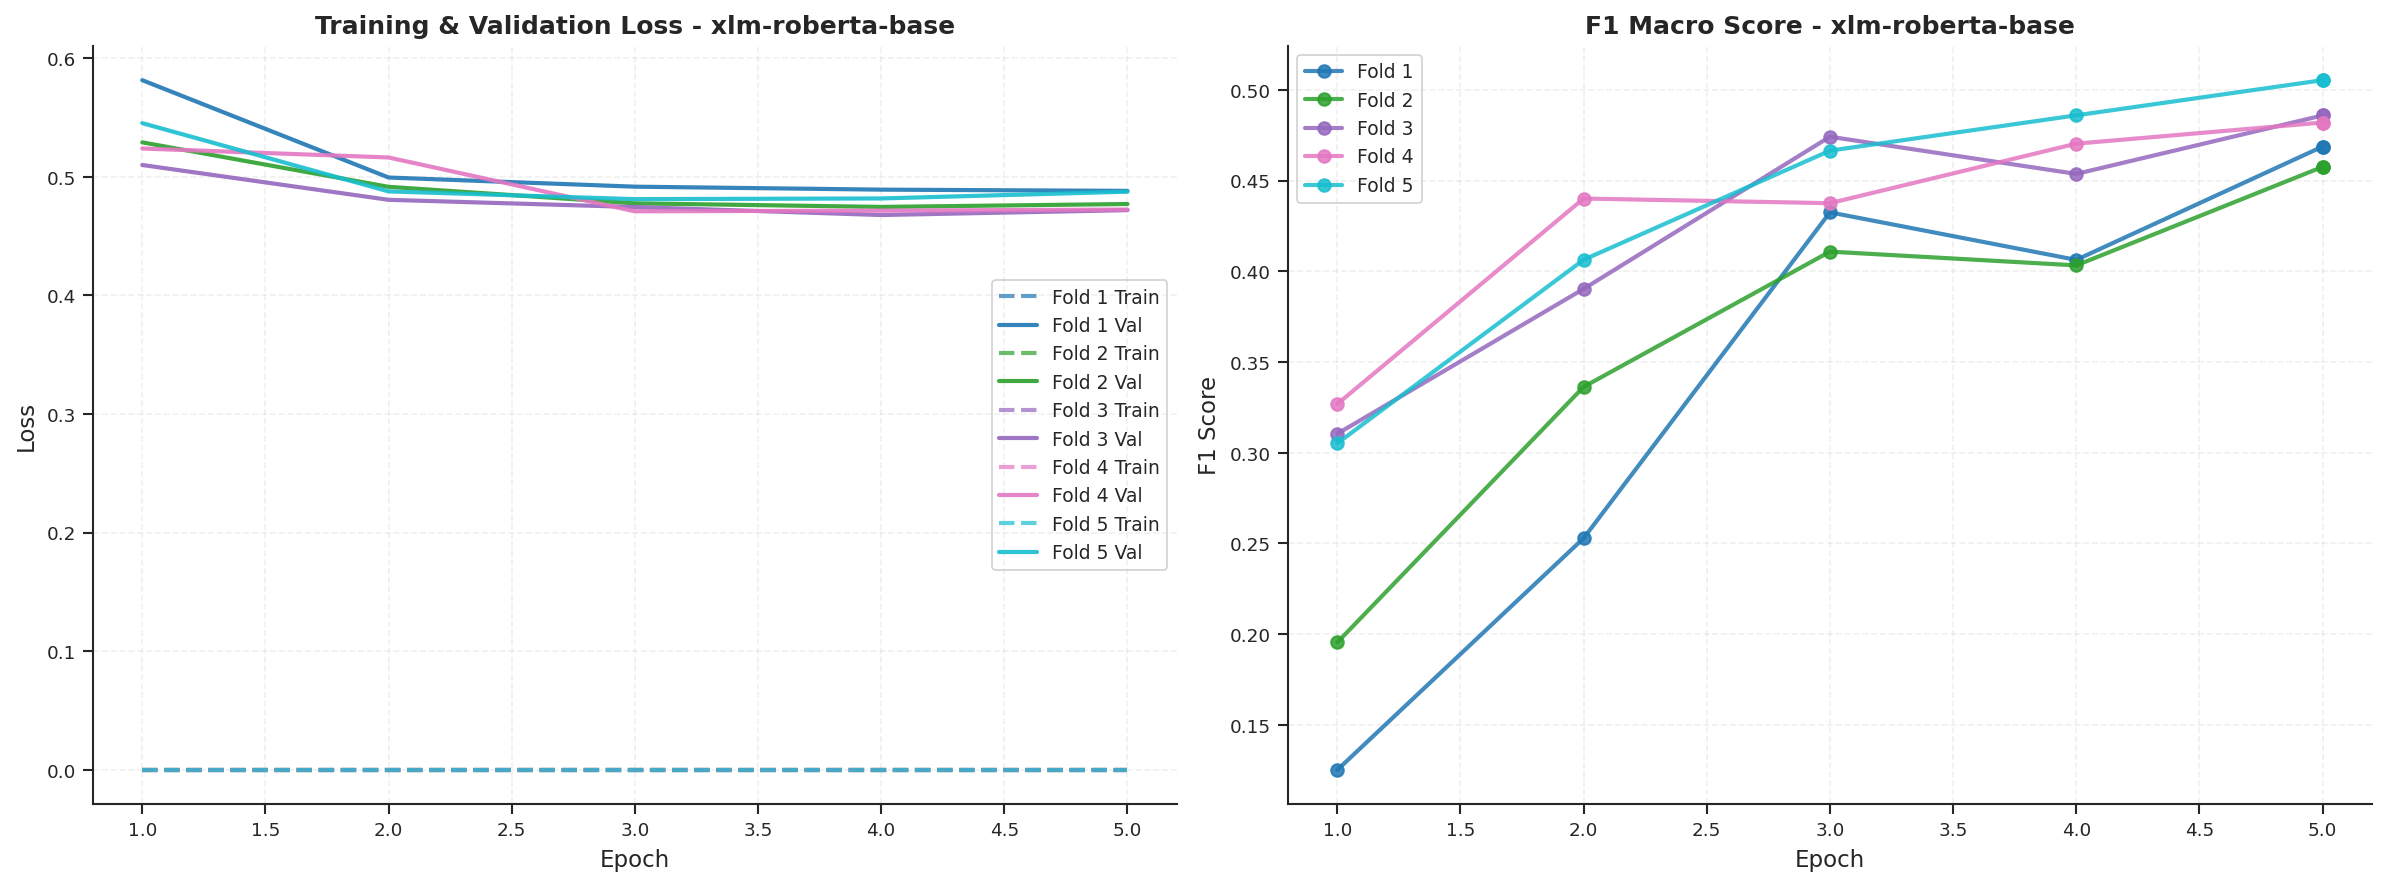


Making Weighted Ensemble Predictions

Getting predictions from Fold 1 (F1: 0.4688)...


Getting predictions from Fold 2 (F1: 0.4576)...


Getting predictions from Fold 3 (F1: 0.4859)...


Getting predictions from Fold 4 (F1: 0.4820)...


Getting predictions from Fold 5 (F1: 0.5054)...



Ensemble weights: [0.19534431 0.19068358 0.20249891 0.20087445 0.21059875]

✓ Saved predictions to subtask_3/pred_swa.csv

Sample predictions:
                                     id  stereotype  vilification  \
0  swa_a5748df181277341143f7da4175add4a           1             1   
1  swa_2df0d42f9b49ea2e4fb006b2e6604e6d           1             1   
2  swa_3718757514005767302b7220b08e409d           1             1   
3  swa_9fa3337a35cce723d60c06056d422330           1             1   
4  swa_5c39ac8ef70345e9e3c21a47f8769bc0           1             1   
5  swa_257c286fa7c51cb7c688945a23f2628c           1             1   
6  swa_36ab93dbc14eea454ab02c2600d1a8f4           1             1   
7  swa_d5efac5c104f931cdc0233ae0ba51d83           1             1   
8  swa_bb5632760ec46cf270238c2163b3aabb           1             1   
9  swa_96b4fdd8cfb089b397d769319be3006b           1             1   

   dehumanization  extreme_language  lack_of_empathy  invalidation  
0               0          

KeyboardInterrupt: 

In [ ]:
if __name__ == "__main__":
    main()

# ============================================
# USAGE EXAMPLES
# ============================================

# Example 1: Train new model (default)
# if __name__ == "__main__":
#     main()

# Example 2: Load saved model and make predictions (single best model)
# if __name__ == "__main__":
#     predictions = predict_with_saved_model(
#         test_csv_path='subtask3/dev/eng.csv',
#         language='english',
#         model_name='twitter-roberta-base-2022-154m',
#         output_csv='new_predictions.csv',
#         threshold=0.5
#     )

# Example 3: Load ALL fold models and make ensemble predictions
# if __name__ == "__main__":
#     predictions = ensemble_predict_with_saved_models(
#         test_csv_path='subtask3/dev/eng.csv',
#         language='english',
#         model_name='twitter-roberta-base-2022-154m',
#         method='weighted_combined',
#         output_csv='ensemble_predictions.csv',
#         threshold=0.5
#     )